In [1]:
import numpy as np
import pandas as pd
import datetime as dt

pd.set_option('display.max_rows', 16)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 9.0)
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import gc

In [2]:
plt.rcParams['figure.figsize'] = (16.0, 9.0)

# Data

In [3]:
START = '2007-01-01'
END = '2023-03-31'

In [4]:
# Security Id
stk_info = DataAPI.SecIDGet(assetClass="E",pandas="1")
cond1 = (stk_info['exchangeCD'] == 'XSHE') | (stk_info['exchangeCD'] == 'XSHG')
cond2 = (stk_info['listStatusCD'] == 'L') | (stk_info['listStatusCD'] == 'DE')
cond3 = stk_info['transCurrCD']=='CNY'
stk_info = stk_info[cond1 & cond2 & cond3].copy()
stk_id = stk_info['secID']

In [5]:
stk_id.nunique()

5131

## ST

In [6]:
st_df = DataAPI.SecSTGet(beginDate=START,endDate=END,secID=stk_id,field=['secID','tradeDate','STflg'],pandas="1")
st_df['tradeDate'] = pd.to_datetime(st_df['tradeDate'],format="%Y-%m-%d")

## Risk free rate

In [7]:
shibor_df = DataAPI.MktIborGet(secID="Shibor1M.IRCN",beginDate=START,endDate=END,field=['secID','tradeDate','rate'],pandas="1")
shibor_df['rate'] = shibor_df['rate']*0.01/12
shibor_df['tradeDate'] = pd.to_datetime(shibor_df['tradeDate'])
shibor_df.drop('secID',axis=1,inplace=True)
shibor_df.rename(columns={'rate':'rf'},inplace=True)
shibor_df['ym'] = shibor_df['tradeDate'].dt.to_period('M')
shibor_df.sort_values('tradeDate',inplace=True)
shibor_df_m = shibor_df.groupby('ym',as_index=False).last()
shibor_df_m.drop('tradeDate',axis=1,inplace=True)
shibor_df_m

ym        rf
0    2007-01  0.002100
1    2007-02  0.002110
2    2007-03  0.002234
3    2007-04  0.002125
4    2007-05  0.002527
5    2007-06  0.002542
6    2007-07  0.002481
7    2007-08  0.002404
..       ...       ...
187  2022-08  0.001251
188  2022-09  0.001426
189  2022-10  0.001400
190  2022-11  0.001596
191  2022-12  0.001955
192  2023-01  0.001856
193  2023-02  0.001910
194  2023-03  0.001970

[195 rows x 2 columns]

## Beta

In [8]:
beta_df = pd.read_pickle('./data/beta_df.pkl')
beta_df['tradeDate'] = pd.to_datetime(beta_df['tradeDate'], format="%Y-%m-%d")
beta_df['ym'] = beta_df['tradeDate'].dt.to_period('M')
beta_df.drop(['Beta60','Beta120'],axis=1,inplace=True)
beta_df['Beta252'] = pd.to_numeric(beta_df['Beta252'])
# Winsorization
# up_q = 0.99999
# lower_q = 0.00001
# beta_df['Beta252_winsor'] = beta_df['Beta252'].clip(lower=beta_df['Beta252'].quantile(lower_q),upper=beta_df['Beta252'].quantile(up_q))
# Monthly
beta_df_m = beta_df.groupby(['secID','ym'],as_index=False)['Beta252'].last()
beta_df_m.rename(columns={'Beta252':'beta'},inplace=True)
beta_df_m

secID       ym    beta
0       000001.XSHE  2007-01  0.7949
1       000001.XSHE  2007-02  0.7880
2       000001.XSHE  2007-03  0.8512
3       000001.XSHE  2007-04  0.8642
4       000001.XSHE  2007-05  0.7715
5       000001.XSHE  2007-06  0.4614
6       000001.XSHE  2007-07  0.6423
7       000001.XSHE  2007-08  0.7722
...             ...      ...     ...
554352  689009.XSHG  2022-07  0.7987
554353  689009.XSHG  2022-08  0.8589
554354  689009.XSHG  2022-09  0.9106
554355  689009.XSHG  2022-10  0.7083
554356  689009.XSHG  2022-11  0.7363
554357  689009.XSHG  2022-12  0.6919
554358  689009.XSHG  2023-01  0.7379
554359  689009.XSHG  2023-02  0.7453

[554360 rows x 3 columns]

## BM

In [9]:
pb_df = pd.read_pickle('./data/pb_df.pkl')
pb_df['tradeDate'] = pd.to_datetime(pb_df['tradeDate'])
pb_df['PB'] = pd.to_numeric(pb_df['PB'])
pb_df['ym'] = pb_df['tradeDate'].dt.to_period('M')
pb_df.sort_values(['secID','tradeDate'],inplace=True)
pb_df = pb_df.groupby(['secID','ym'],as_index=False).last()
pb_df['bm'] = 1 / pb_df['PB']
pb_df.drop(['tradeDate','PB'],axis=1,inplace=True)
pb_df = pb_df[pb_df['bm'] >= 0]
pb_df

secID       ym        bm
0       000001.XSHE  2007-01  0.162639
1       000001.XSHE  2007-02  0.163321
2       000001.XSHE  2007-03  0.176236
3       000001.XSHE  2007-04  0.140732
4       000001.XSHE  2007-05  0.127291
5       000001.XSHE  2007-06  0.123739
6       000001.XSHE  2007-07  0.093992
7       000001.XSHE  2007-08  0.097085
...             ...      ...       ...
559224  689009.XSHG  2022-08  0.146757
559225  689009.XSHG  2022-09  0.168319
559226  689009.XSHG  2022-10  0.209701
559227  689009.XSHG  2022-11  0.201033
559228  689009.XSHG  2022-12  0.220085
559229  689009.XSHG  2023-01  0.201772
559230  689009.XSHG  2023-02  0.202930
559231  689009.XSHG  2023-03  0.193716

[551945 rows x 3 columns]

## Trading data

In [10]:
# %%time
# # About 8 mins
# # # 从优矿下载股票信息，时间较长。由于优矿的限制，每次下载3年的数据

# stk_dict = {}
# begin_ = dt.datetime.strptime(START, '%Y-%m-%d').year
# end_ = dt.datetime.strptime(START, '%Y-%m-%d').year+3
# field = ['secID','tradeDate','preClosePrice','closePrice','negMarketValue','turnoverValue','turnoverRate']
# while begin_ <= 2023:
#     if begin_ == 2023:
#         yesterday = dt.datetime.today() - dt.timedelta(days=1)
#         yesterday.strftime('%Y%m%d')
#         stk_dict[begin_] = DataAPI.MktEqudAdjAfGet(secID=stk_id,
#                                                      beginDate=f'{begin_}0101',
#                                                      endDate=yesterday,
#                                                      field=field,pandas="1")
#     else:
#         stk_dict[begin_] = DataAPI.MktEqudAdjAfGet(secID=stk_id,
#                                                          beginDate=f'{begin_}0101',
#                                                          endDate=f'{end_}1231',
#                                                          field=field,pandas="1")
#     begin_ = end_ + 1
#     end_ = begin_ + 3
    
# for i in range(len(stk_dict)):
#     stk_df = pd.DataFrame(np.vstack([_df for _df in stk_dict.values()]),columns=field)
    
# stk_df.to_pickle('./data/stk_df.pkl')

In [11]:
stk_df = pd.read_pickle('./data/stk_df.pkl')
stk_df['tradeDate'] = pd.to_datetime(stk_df['tradeDate'], format='%Y-%m-%d')
stk_df.sort_values(['secID','tradeDate'],inplace=True)
# drop ST stocks
print(stk_df.shape)
stk_df = pd.merge(stk_df, st_df, on=['secID','tradeDate'],how='left')
stk_df = stk_df[stk_df['STflg'].isna()].copy()
stk_df.drop('STflg',axis=1,inplace=True)
print(stk_df.shape)

(11220557, 7)
(10702693, 7)


In [12]:
num_cols = ['preClosePrice','closePrice','negMarketValue','turnoverValue','turnoverRate']
for col in num_cols:
    stk_df[col] = pd.to_numeric(stk_df[col])

In [13]:
stk_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10702693 entries, 109 to 11220556
Data columns (total 7 columns):
secID             object
tradeDate         datetime64[ns]
preClosePrice     float64
closePrice        float64
negMarketValue    float64
turnoverValue     float64
turnoverRate      float64
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 653.2+ MB


In [14]:
# # # If the trading days are required to be consecutive, fill missing days first. This could possibly produce a much larger df when using 
# ## daily data, and if the missing dates are a lot for some securities

# def fill_missing(df, full_dates, id_col='secID', date_col='tradeDate'):
#     """
#     This function fills the missing dates for stocks.
#     Parameters:
#         df: The dataframe. Could be a sub-dataframe created by "groupby".
#             The dataframe must be sorted on the "date_col".
#         full_dates: the unique dates covering all securities in the full dataframe. 
#                     Need to be sorted.
#         id_col: the security id.
#         date_col: the dates column for the security
#     Returns:
#         A dataframe with the missing dates filled with NA.
#     """
#     stk_id = df[id_col].unique()
#     # Newer version of pandas will allow comparison between "Timestamp" and "datetime64"
# #     date_start = np.where(full_dates == df[date_col].min())[0][0] 
# #     date_end = np.where(full_dates == df[date_col].max())[0][0]
#     date_start = np.where(full_dates == df[date_col].min().to_datetime64())[0][0] 
#     date_end = np.where(full_dates == df[date_col].max().to_datetime64())[0][0]
#     dates = full_dates[date_start:date_end+1]
#     idx = pd.MultiIndex.from_product([stk_id,dates],
#                                      names=(id_col,date_col))
#     df = df.set_index([id_col,date_col]).reindex(idx).reset_index()
#     return df

In [15]:
# full_dates = np.sort(stk_df['tradeDate'].unique())

In [16]:
# full_dates

In [17]:
# %%time
# stk_df = stk_df.groupby('secID').apply(fill_missing, full_dates=full_dates)

## Amihud (2002) liquidity

Amihud (2002)'s liquidity measure is perhaps the most widely known.

$$ illiq_i = \frac{1}{D} \sum^D_{d=1} \frac{|R_{i,d}|}{VOLD_{i,d}} $$

VOLD: the dollar volume, measured as "close_price * shares_traded"

Intuition: the effect of volume on moving prices. If a small volume moves price significantly (nonsignificantly), the stock is quite illiquid (liquid).

Period choices: Amihud(2002) uses t-11 month through t month (12 months) daily data as the measure for month t. 

Let's use the two measures: 
- Amihud's original measure, but we do not stick to calendar month. Let's use 250 trading days.
- a simple one: one-month daily data.

Also, let's use the actual dollar volume within one day

- Acharya and Pedersen (2005): liquidity should be positively correlated with contemporaneous returns, and negatively with future returns
- 其他相关文献， Bali, Peng, Shen, and Tang (2014)，Chordia, Roll and Subrahmanyam (2000)
- Pastor and Stambaugh (2003): Aggregate liquidity factor.

In [18]:
# stk_df

In [19]:
# stk_df.reset_index(drop=True, inplace=True)

# stk_df['ret_daily'] = stk_df['closePrice'] / stk_df['preClosePrice'] - 1
# stk_df['illiq_daily'] = abs(stk_df['ret_daily'].values) / stk_df['turnoverValue'].values
# stk_df.loc[np.isinf(stk_df['illiq_daily']),'illiq_daily'] = np.nan
# stk_df['ym'] = stk_df['tradeDate'].dt.to_period('M')

# stk_df.to_pickle('./data/stk_df_filled.pkl')

In [20]:
stk_df = pd.read_pickle('./data/stk_df_filled.pkl')

In [21]:
stk_df.loc[np.isinf(stk_df['illiq_daily'])]

Empty DataFrame
Columns: [secID, tradeDate, preClosePrice, closePrice, negMarketValue, turnoverValue, turnoverRate, ret_daily, illiq_daily, ym]
Index: []

In [22]:
stk_df[(stk_df['secID']=='000001.XSHE') & (stk_df['tradeDate']>='2010-06-01') & (stk_df['tradeDate']<='2010-09-05')]

secID  tradeDate  preClosePrice  closePrice  negMarketValue  \
722  000001.XSHE 2010-06-01        722.475     713.810    5.058718e+10   
723  000001.XSHE 2010-06-02        713.810     710.922    5.038249e+10   
724  000001.XSHE 2010-06-03        710.922     710.509    5.035325e+10   
725  000001.XSHE 2010-06-04        710.509     713.810    5.058718e+10   
726  000001.XSHE 2010-06-07        713.810     697.718    4.944677e+10   
727  000001.XSHE 2010-06-08        697.718     689.054    4.883271e+10   
728  000001.XSHE 2010-06-09        689.054     729.077    5.166910e+10   
729  000001.XSHE 2010-06-10        729.077     705.971    5.003160e+10   
..           ...        ...            ...         ...             ...   
780  000001.XSHE 2010-08-25        722.475     722.475    5.437499e+10   
781  000001.XSHE 2010-08-26        722.475     722.475    5.437499e+10   
782  000001.XSHE 2010-08-27        722.475     722.475    5.437499e+10   
783  000001.XSHE 2010-08-30        722.475     722.475    5.437499e+10   
784  000001.XSHE 2010-08-31        722.475     722.475    5.437499e+10   
785  000001.XSHE 2010-09-01        722.475     722.475    5.437499e+10   
786  000001.XSHE 2010-09-02        722.475     750.532    5.648664e+10   
787  000001.XSHE 2010-09-03        750.532     732.790    5.515133e+10   

     turnoverValue  turnoverRate  ret_daily   illiq_daily       ym  
722   3.790589e+08        0.0075  -0.011993  3.164019e-11  2010-06  
723   4.307207e+08        0.0086  -0.004046  9.393313e-12  2010-06  
724   5.011432e+08        0.0098  -0.000581  1.159221e-12  2010-06  
725   2.328248e+08        0.0046   0.004646  1.995477e-11  2010-06  
726   4.105509e+08        0.0083  -0.022544  5.491113e-11  2010-06  
727   2.861562e+08        0.0058  -0.012418  4.339457e-11  2010-06  
728   8.579786e+08        0.0170   0.058084  6.769864e-11  2010-06  
729   4.895630e+08        0.0097  -0.031692  6.473554e-11  2010-06  
..             ...           ...        ...           ...      ...  
780   0.000000e+00        0.0000   0.000000           NaN  2010-08  
781   0.000000e+00        0.0000   0.000000           NaN  2010-08  
782   0.000000e+00        0.0000   0.000000           NaN  2010-08  
783   0.000000e+00        0.0000   0.000000           NaN  2010-08  
784   0.000000e+00        0.0000   0.000000           NaN  2010-08  
785   0.000000e+00        0.0000   0.000000           NaN  2010-09  
786   2.984709e+09        0.0526   0.038835  1.301117e-11  2010-09  
787   1.110874e+09        0.0201  -0.023639  2.127986e-11  2010-09  

[66 rows x 10 columns]

### Monthly trading data

In [23]:
stk_df_m = stk_df.groupby(['secID','ym'],as_index=False).last()
stk_df_m['ret'] = stk_df_m.groupby('secID')['closePrice'].apply(lambda x: x / x.shift() - 1)
stk_df_m['size'] = np.log(stk_df_m['negMarketValue'])
stk_df_m.drop(['preClosePrice'],axis=1,inplace=True)
stk_df_m = pd.merge(stk_df_m, shibor_df_m, on='ym')
stk_df_m['exret'] = stk_df_m['ret'] - stk_df_m['rf']
stk_df_m.sort_values(['secID','ym'],inplace=True)
stk_df_m.rename(columns={'negMarketValue':'mktcap'},inplace=True)
stk_df_m

secID       ym  tradeDate  closePrice        mktcap  \
0       000001.XSHE  2007-06 2007-06-29     870.870  4.266117e+10   
1293    000001.XSHE  2007-07 2007-07-31    1146.498  5.616330e+10   
2595    000001.XSHE  2007-08 2007-08-31    1202.510  5.890714e+10   
3922    000001.XSHE  2007-09 2007-09-28    1265.167  6.197651e+10   
5264    000001.XSHE  2007-10 2007-10-31    1520.542  7.448652e+10   
6612    000001.XSHE  2007-11 2007-11-30    1141.751  5.593078e+10   
7976    000001.XSHE  2007-12 2007-12-28    1221.497  6.574629e+10   
9362    000001.XSHE  2008-01 2008-01-31    1053.778  5.850212e+10   
...             ...      ...        ...         ...           ...   
508954  689009.XSHG  2022-08 2022-08-31      44.030  2.240616e+10   
513653  689009.XSHG  2022-09 2022-09-30      38.310  1.949535e+10   
518374  689009.XSHG  2022-10 2022-10-31      32.000  1.637440e+10   
523119  689009.XSHG  2022-11 2022-11-30      33.380  1.708055e+10   
527891  689009.XSHG  2022-12 2022-12-30      30.490  1.560173e+10   
532669  689009.XSHG  2023-01 2023-01-31      33.190  1.698332e+10   
537461  689009.XSHG  2023-02 2023-02-28      33.000  1.688610e+10   
542263  689009.XSHG  2023-03 2023-03-10      32.610  1.668654e+10   

        turnoverValue  turnoverRate  ret_daily   illiq_daily       ret  \
0        1.410758e+09        0.0316  -0.086928  6.161781e-11       NaN   
1293     1.479466e+09        0.0270   0.059356  4.012016e-11  0.316497   
2595     6.552881e+08        0.0112   0.007958  1.214425e-11  0.048855   
3922     1.408136e+09        0.0228   0.030147  2.140927e-11  0.052105   
5264     1.440425e+09        0.0200   0.065410  4.541049e-11  0.201851   
6612     5.452159e+08        0.0096  -0.026181  4.801976e-11 -0.249116   
7976     1.019671e+09        0.0154  -0.010256  1.005854e-11  0.069845   
9362     5.328429e+08        0.0089  -0.019146  3.593101e-11 -0.137306   
...               ...           ...        ...           ...       ...   
508954   9.711262e+07        0.0043   0.004105  4.226951e-11 -0.112656   
513653   6.560969e+07        0.0034   0.008158  1.243398e-10 -0.129911   
518374   1.649592e+08        0.0100   0.000000  0.000000e+00 -0.164709   
523119   9.351642e+07        0.0054  -0.017368  1.857242e-10  0.043125   
527891   8.049526e+07        0.0051  -0.011349  1.409884e-10 -0.086579   
532669   1.626498e+08        0.0095   0.010966  6.741836e-11  0.088554   
537461   3.453544e+08        0.0206   0.042325  1.225544e-10 -0.005725   
542263   1.129391e+08        0.0068  -0.023945  2.120162e-10 -0.011818   

             size        rf     exret  
0       24.476555  0.002542       NaN  
1293    24.751529  0.002481  0.314016  
2595    24.799228  0.002404  0.046451  
3922    24.850021  0.002621  0.049484  
5264    25.033884  0.003095  0.198756  
6612    24.747381  0.003780 -0.252896  
7976    24.909069  0.003011  0.066834  
9362    24.792329  0.002949 -0.140255  
...           ...       ...       ...  
508954  23.832602  0.001251 -0.113907  
513653  23.693442  0.001426 -0.131337  
518374  23.518985  0.001400 -0.166109  
523119  23.561206  0.001596  0.041529  
527891  23.470648  0.001955 -0.088534  
532669  23.555498  0.001856  0.086698  
537461  23.549757  0.001910 -0.007635  
542263  23.537868  0.001970 -0.013788  

[548447 rows x 13 columns]

### Momentum and reversal

#### Using unfilled data 

In [24]:
stk_unfilled_df = pd.read_pickle('./data/stk_df.pkl')
stk_unfilled_df['tradeDate'] = pd.to_datetime(stk_unfilled_df['tradeDate'], format='%Y-%m-%d')
stk_unfilled_df['ym'] = stk_unfilled_df['tradeDate'].dt.to_period('M')
stk_unfilled_df.sort_values(['secID','tradeDate'],inplace=True)
# drop ST stocks
print(stk_unfilled_df.shape)
stk_unfilled_df = pd.merge(stk_unfilled_df, st_df, on=['secID','tradeDate'],how='left')
stk_unfilled_df = stk_unfilled_df[stk_unfilled_df['STflg'].isna()].copy()
stk_unfilled_df.drop('STflg',axis=1,inplace=True)
print(stk_unfilled_df.shape)
# Monthly
stk_unfilled_df_m = stk_unfilled_df.groupby(['secID','ym'],as_index=False).last()

(11220557, 8)
(10702693, 8)


In [25]:
stk_unfilled_df_m['ret_mom'] = stk_unfilled_df_m.groupby('secID')['closePrice'].apply(lambda x: x / x.shift() - 1) #这个ret_mom不用作后面ret的计算，后面仍保留monthly ret
stk_unfilled_df_m.sort_values(['secID','ym'],inplace=True)

In [26]:
stk_unfilled_df_m['1+ret_mom'] = stk_unfilled_df_m['ret_mom'] + 1

In [27]:
stk_unfilled_df_m

secID       ym  tradeDate  preClosePrice  closePrice  \
0       000001.XSHE  2007-06 2007-06-29        953.780     870.870   
1       000001.XSHE  2007-07 2007-07-31       1082.259    1146.498   
2       000001.XSHE  2007-08 2007-08-31       1193.016    1202.510   
3       000001.XSHE  2007-09 2007-09-28       1228.142    1265.167   
4       000001.XSHE  2007-10 2007-10-31       1427.189    1520.542   
5       000001.XSHE  2007-11 2007-11-30       1172.447    1141.751   
6       000001.XSHE  2007-12 2007-12-28       1234.155    1221.497   
7       000001.XSHE  2008-01 2008-01-31       1074.347    1053.778   
...             ...      ...        ...            ...         ...   
534396  689009.XSHG  2022-08 2022-08-31         43.850      44.030   
534397  689009.XSHG  2022-09 2022-09-30         38.000      38.310   
534398  689009.XSHG  2022-10 2022-10-31         32.000      32.000   
534399  689009.XSHG  2022-11 2022-11-30         33.970      33.380   
534400  689009.XSHG  2022-12 2022-12-30         30.840      30.490   
534401  689009.XSHG  2023-01 2023-01-31         32.830      33.190   
534402  689009.XSHG  2023-02 2023-02-28         31.660      33.000   
534403  689009.XSHG  2023-03 2023-03-10         33.410      32.610   

        negMarketValue  turnoverValue  turnoverRate   ret_mom  1+ret_mom  
0         4.266117e+10   1.410758e+09        0.0316       NaN        NaN  
1         5.616330e+10   1.479466e+09        0.0270  0.316497   1.316497  
2         5.890714e+10   6.552881e+08        0.0112  0.048855   1.048855  
3         6.197651e+10   1.408136e+09        0.0228  0.052105   1.052105  
4         7.448652e+10   1.440425e+09        0.0200  0.201851   1.201851  
5         5.593078e+10   5.452159e+08        0.0096 -0.249116   0.750884  
6         6.574629e+10   1.019671e+09        0.0154  0.069845   1.069845  
7         5.850212e+10   5.328429e+08        0.0089 -0.137306   0.862694  
...                ...            ...           ...       ...        ...  
534396    2.240616e+10   9.711262e+07        0.0043 -0.112656   0.887344  
534397    1.949535e+10   6.560969e+07        0.0034 -0.129911   0.870089  
534398    1.637440e+10   1.649592e+08        0.0100 -0.164709   0.835291  
534399    1.708055e+10   9.351642e+07        0.0054  0.043125   1.043125  
534400    1.560173e+10   8.049526e+07        0.0051 -0.086579   0.913421  
534401    1.698332e+10   1.626498e+08        0.0095  0.088554   1.088554  
534402    1.688610e+10   3.453544e+08        0.0206 -0.005725   0.994275  
534403    1.668654e+10   1.129391e+08        0.0068 -0.011818   0.988182  

[534404 rows x 10 columns]

In [28]:
stk_unfilled_df_m['mom'] = stk_unfilled_df_m.groupby('secID').rolling(11,min_periods=9)['1+ret_mom'].apply(np.prod, raw=True).values - 1

In [29]:
stk_unfilled_df_m

secID       ym  tradeDate  preClosePrice  closePrice  \
0       000001.XSHE  2007-06 2007-06-29        953.780     870.870   
1       000001.XSHE  2007-07 2007-07-31       1082.259    1146.498   
2       000001.XSHE  2007-08 2007-08-31       1193.016    1202.510   
3       000001.XSHE  2007-09 2007-09-28       1228.142    1265.167   
4       000001.XSHE  2007-10 2007-10-31       1427.189    1520.542   
5       000001.XSHE  2007-11 2007-11-30       1172.447    1141.751   
6       000001.XSHE  2007-12 2007-12-28       1234.155    1221.497   
7       000001.XSHE  2008-01 2008-01-31       1074.347    1053.778   
...             ...      ...        ...            ...         ...   
534396  689009.XSHG  2022-08 2022-08-31         43.850      44.030   
534397  689009.XSHG  2022-09 2022-09-30         38.000      38.310   
534398  689009.XSHG  2022-10 2022-10-31         32.000      32.000   
534399  689009.XSHG  2022-11 2022-11-30         33.970      33.380   
534400  689009.XSHG  2022-12 2022-12-30         30.840      30.490   
534401  689009.XSHG  2023-01 2023-01-31         32.830      33.190   
534402  689009.XSHG  2023-02 2023-02-28         31.660      33.000   
534403  689009.XSHG  2023-03 2023-03-10         33.410      32.610   

        negMarketValue  turnoverValue  turnoverRate   ret_mom  1+ret_mom  \
0         4.266117e+10   1.410758e+09        0.0316       NaN        NaN   
1         5.616330e+10   1.479466e+09        0.0270  0.316497   1.316497   
2         5.890714e+10   6.552881e+08        0.0112  0.048855   1.048855   
3         6.197651e+10   1.408136e+09        0.0228  0.052105   1.052105   
4         7.448652e+10   1.440425e+09        0.0200  0.201851   1.201851   
5         5.593078e+10   5.452159e+08        0.0096 -0.249116   0.750884   
6         6.574629e+10   1.019671e+09        0.0154  0.069845   1.069845   
7         5.850212e+10   5.328429e+08        0.0089 -0.137306   0.862694   
...                ...            ...           ...       ...        ...   
534396    2.240616e+10   9.711262e+07        0.0043 -0.112656   0.887344   
534397    1.949535e+10   6.560969e+07        0.0034 -0.129911   0.870089   
534398    1.637440e+10   1.649592e+08        0.0100 -0.164709   0.835291   
534399    1.708055e+10   9.351642e+07        0.0054  0.043125   1.043125   
534400    1.560173e+10   8.049526e+07        0.0051 -0.086579   0.913421   
534401    1.698332e+10   1.626498e+08        0.0095  0.088554   1.088554   
534402    1.688610e+10   3.453544e+08        0.0206 -0.005725   0.994275   
534403    1.668654e+10   1.129391e+08        0.0068 -0.011818   0.988182   

             mom  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
5            NaN  
6            NaN  
7            NaN  
...          ...  
534396 -0.455748  
534397 -0.401406  
534398 -0.474030  
534399 -0.523619  
534400 -0.498602  
534401 -0.418230  
534402 -0.246403  
534403 -0.122916  

[534404 rows x 11 columns]

In [30]:
stk_df_m = pd.merge(stk_df_m, stk_unfilled_df_m[['secID','ym','1+ret_mom']],on=['secID','ym'],how='left')

In [31]:
stk_df_m[(stk_df_m['secID']=='000001.XSHE') & (stk_df_m['ym']>='2010-06') & (stk_df_m['ym']<='2010-10')]

secID       ym  tradeDate  closePrice        mktcap  turnoverValue  \
36  000001.XSHE  2010-06 2010-06-30     722.475  5.437499e+10            0.0   
37  000001.XSHE  2010-07 2010-07-30     722.475  5.437499e+10            0.0   
38  000001.XSHE  2010-08 2010-08-31     722.475  5.437499e+10            0.0   
39  000001.XSHE  2010-09 2010-09-30     669.249  5.036906e+10            0.0   
40  000001.XSHE  2010-10 2010-10-29     759.610  5.716982e+10    663509380.0   

    turnoverRate  ret_daily   illiq_daily       ret       size        rf  \
36        0.0000   0.000000  9.651729e-11  0.000000  24.719170  0.003236   
37        0.0000   0.000000           NaN  0.000000  24.719170  0.001798   
38        0.0000   0.000000           NaN  0.000000  24.719170  0.002369   
39        0.0000   0.000000  7.082247e-12 -0.073672  24.642643  0.002922   
40        0.0115  -0.019178  2.890457e-11  0.135019  24.769292  0.002214   

       exret  1+ret_mom  
36 -0.003236   1.000000  
37 -0.001798   1.000000  
38 -0.002369   1.000000  
39 -0.076594   0.926328  
40  0.132805   1.135019

In [32]:
stk_df_m[(stk_df_m['secID']=='000007.XSHE')&(stk_df_m['ym']>='2021-02')]

secID       ym  tradeDate  closePrice        mktcap  \
1036  000007.XSHE  2021-02 2021-02-26      48.845  1.254329e+09   
1037  000007.XSHE  2021-03 2021-03-31      46.559  1.195629e+09   
1038  000007.XSHE  2021-04 2021-04-30      47.401  1.217255e+09   
1039  000007.XSHE  2021-05 2021-05-31         NaN           NaN   
1040  000007.XSHE  2021-06 2021-06-30         NaN           NaN   
1041  000007.XSHE  2021-07 2021-07-30         NaN           NaN   
1042  000007.XSHE  2021-08 2021-08-31         NaN           NaN   
1043  000007.XSHE  2021-09 2021-09-30         NaN           NaN   
...           ...      ...        ...         ...           ...   
1054  000007.XSHE  2022-08 2022-08-31      96.727  2.483942e+09   
1055  000007.XSHE  2022-09 2022-09-30      96.968  2.490121e+09   
1056  000007.XSHE  2022-10 2022-10-31      96.246  2.471584e+09   
1057  000007.XSHE  2022-11 2022-11-30      90.712  2.329468e+09   
1058  000007.XSHE  2022-12 2022-12-30      93.599  2.403615e+09   
1059  000007.XSHE  2023-01 2023-01-31      91.674  2.354184e+09   
1060  000007.XSHE  2023-02 2023-02-28      93.118  2.391258e+09   
1061  000007.XSHE  2023-03 2023-03-10      93.118  2.391258e+09   

      turnoverValue  turnoverRate  ret_daily   illiq_daily       ret  \
1036   2.533973e+08        0.2129   0.100286  3.957662e-10  0.537892   
1037   1.236837e+08        0.1049   0.099438  8.039699e-10 -0.046801   
1038   0.000000e+00        0.0000   0.000000  4.929238e-10  0.018085   
1039            NaN           NaN        NaN           NaN       NaN   
1040            NaN           NaN        NaN           NaN       NaN   
1041            NaN           NaN        NaN           NaN       NaN   
1042            NaN           NaN        NaN           NaN       NaN   
1043            NaN           NaN        NaN           NaN       NaN   
...             ...           ...        ...           ...       ...   
1054   9.637280e+07        0.0390   0.000000  0.000000e+00  0.090902   
1055   9.732263e+07        0.0393   0.025444  2.614358e-10  0.002492   
1056   1.660016e+08        0.0676   0.006284  3.785298e-11 -0.007446   
1057   9.954794e+07        0.0429  -0.005275  5.298480e-11 -0.057498   
1058   1.935804e+07        0.0081   0.000000  0.000000e+00  0.031826   
1059   3.456774e+07        0.0148   0.020073  5.806986e-10 -0.020566   
1060   3.875115e+07        0.0163   0.021109  5.447343e-10  0.015751   
1061   3.673496e+07        0.0155   0.022455  6.112574e-10  0.000000   

           size        rf     exret  1+ret_mom  
1036  20.949867  0.002266  0.535627   1.537892  
1037  20.901938  0.002118 -0.048919   0.953199  
1038  20.919864  0.002074  0.016010   1.018085  
1039        NaN  0.002006       NaN        NaN  
1040        NaN  0.002012       NaN        NaN  
1041        NaN  0.001942       NaN        NaN  
1042        NaN  0.001941       NaN        NaN  
1043        NaN  0.002033       NaN        NaN  
...         ...       ...       ...        ...  
1054  21.633113  0.001251  0.089651   1.090902  
1055  21.635597  0.001426  0.001066   1.002492  
1056  21.628125  0.001400 -0.008846   0.992554  
1057  21.568906  0.001596 -0.059094   0.942502  
1058  21.600240  0.001955  0.029871   1.031826  
1059  21.579460  0.001856 -0.022422   0.979434  
1060  21.595085  0.001910  0.013841   1.015751  
1061  21.595085  0.001970 -0.001970   1.000000  

[26 rows x 14 columns]

In [33]:
stk_df_m.loc[stk_df_m['1+ret_mom'].isna(),'1+ret_mom'] = 1 # 缺失位置填充为1，以便连乘。

In [34]:
stk_df_m['mom'] = stk_df_m.groupby('secID').rolling(11,min_periods=11)['1+ret_mom'].apply(np.prod, raw=True).values - 1 

In [35]:
stk_df_m

secID       ym  tradeDate  closePrice        mktcap  \
0       000001.XSHE  2007-06 2007-06-29     870.870  4.266117e+10   
1       000001.XSHE  2007-07 2007-07-31    1146.498  5.616330e+10   
2       000001.XSHE  2007-08 2007-08-31    1202.510  5.890714e+10   
3       000001.XSHE  2007-09 2007-09-28    1265.167  6.197651e+10   
4       000001.XSHE  2007-10 2007-10-31    1520.542  7.448652e+10   
5       000001.XSHE  2007-11 2007-11-30    1141.751  5.593078e+10   
6       000001.XSHE  2007-12 2007-12-28    1221.497  6.574629e+10   
7       000001.XSHE  2008-01 2008-01-31    1053.778  5.850212e+10   
...             ...      ...        ...         ...           ...   
548439  689009.XSHG  2022-08 2022-08-31      44.030  2.240616e+10   
548440  689009.XSHG  2022-09 2022-09-30      38.310  1.949535e+10   
548441  689009.XSHG  2022-10 2022-10-31      32.000  1.637440e+10   
548442  689009.XSHG  2022-11 2022-11-30      33.380  1.708055e+10   
548443  689009.XSHG  2022-12 2022-12-30      30.490  1.560173e+10   
548444  689009.XSHG  2023-01 2023-01-31      33.190  1.698332e+10   
548445  689009.XSHG  2023-02 2023-02-28      33.000  1.688610e+10   
548446  689009.XSHG  2023-03 2023-03-10      32.610  1.668654e+10   

        turnoverValue  turnoverRate  ret_daily   illiq_daily       ret  \
0        1.410758e+09        0.0316  -0.086928  6.161781e-11       NaN   
1        1.479466e+09        0.0270   0.059356  4.012016e-11  0.316497   
2        6.552881e+08        0.0112   0.007958  1.214425e-11  0.048855   
3        1.408136e+09        0.0228   0.030147  2.140927e-11  0.052105   
4        1.440425e+09        0.0200   0.065410  4.541049e-11  0.201851   
5        5.452159e+08        0.0096  -0.026181  4.801976e-11 -0.249116   
6        1.019671e+09        0.0154  -0.010256  1.005854e-11  0.069845   
7        5.328429e+08        0.0089  -0.019146  3.593101e-11 -0.137306   
...               ...           ...        ...           ...       ...   
548439   9.711262e+07        0.0043   0.004105  4.226951e-11 -0.112656   
548440   6.560969e+07        0.0034   0.008158  1.243398e-10 -0.129911   
548441   1.649592e+08        0.0100   0.000000  0.000000e+00 -0.164709   
548442   9.351642e+07        0.0054  -0.017368  1.857242e-10  0.043125   
548443   8.049526e+07        0.0051  -0.011349  1.409884e-10 -0.086579   
548444   1.626498e+08        0.0095   0.010966  6.741836e-11  0.088554   
548445   3.453544e+08        0.0206   0.042325  1.225544e-10 -0.005725   
548446   1.129391e+08        0.0068  -0.023945  2.120162e-10 -0.011818   

             size        rf     exret  1+ret_mom       mom  
0       24.476555  0.002542       NaN   1.000000       NaN  
1       24.751529  0.002481  0.314016   1.316497       NaN  
2       24.799228  0.002404  0.046451   1.048855       NaN  
3       24.850021  0.002621  0.049484   1.052105       NaN  
4       25.033884  0.003095  0.198756   1.201851       NaN  
5       24.747381  0.003780 -0.252896   0.750884       NaN  
6       24.909069  0.003011  0.066834   1.069845       NaN  
7       24.792329  0.002949 -0.140255   0.862694       NaN  
...           ...       ...       ...        ...       ...  
548439  23.832602  0.001251 -0.113907   0.887344 -0.455748  
548440  23.693442  0.001426 -0.131337   0.870089 -0.401406  
548441  23.518985  0.001400 -0.166109   0.835291 -0.474030  
548442  23.561206  0.001596  0.041529   1.043125 -0.523619  
548443  23.470648  0.001955 -0.088534   0.913421 -0.498602  
548444  23.555498  0.001856  0.086698   1.088554 -0.418230  
548445  23.549757  0.001910 -0.007635   0.994275 -0.246403  
548446  23.537868  0.001970 -0.013788   0.988182 -0.122916  

[548447 rows x 15 columns]

In [36]:
stk_df_m['rev'] = stk_df_m['exret'].values
stk_df_m['ret'] = stk_df_m.groupby(['secID'])['ret'].shift(-1)
stk_df_m['rf'] = stk_df_m.groupby(['secID'])['rf'].shift(-1)
stk_df_m['exret'] = stk_df_m.groupby(['secID'])['exret'].shift(-1)
stk_df_m['ret_date'] = stk_df_m.groupby('secID')['ym'].shift(-1)

stk_df_m['mom'] = stk_df_m.groupby(['secID'])['mom'].shift()
stk_df_m['mom_date'] = stk_df_m.groupby('secID')['ym'].shift()

In [37]:
stk_df_m.drop(['ret_daily','turnoverValue','turnoverRate','illiq_daily','1+ret_mom'],axis=1,inplace=True)

In [38]:
stk_df_m

secID       ym  tradeDate  closePrice        mktcap       ret  \
0       000001.XSHE  2007-06 2007-06-29     870.870  4.266117e+10  0.316497   
1       000001.XSHE  2007-07 2007-07-31    1146.498  5.616330e+10  0.048855   
2       000001.XSHE  2007-08 2007-08-31    1202.510  5.890714e+10  0.052105   
3       000001.XSHE  2007-09 2007-09-28    1265.167  6.197651e+10  0.201851   
4       000001.XSHE  2007-10 2007-10-31    1520.542  7.448652e+10 -0.249116   
5       000001.XSHE  2007-11 2007-11-30    1141.751  5.593078e+10  0.069845   
6       000001.XSHE  2007-12 2007-12-28    1221.497  6.574629e+10 -0.137306   
7       000001.XSHE  2008-01 2008-01-31    1053.778  5.850212e+10 -0.004504   
...             ...      ...        ...         ...           ...       ...   
548439  689009.XSHG  2022-08 2022-08-31      44.030  2.240616e+10 -0.129911   
548440  689009.XSHG  2022-09 2022-09-30      38.310  1.949535e+10 -0.164709   
548441  689009.XSHG  2022-10 2022-10-31      32.000  1.637440e+10  0.043125   
548442  689009.XSHG  2022-11 2022-11-30      33.380  1.708055e+10 -0.086579   
548443  689009.XSHG  2022-12 2022-12-30      30.490  1.560173e+10  0.088554   
548444  689009.XSHG  2023-01 2023-01-31      33.190  1.698332e+10 -0.005725   
548445  689009.XSHG  2023-02 2023-02-28      33.000  1.688610e+10 -0.011818   
548446  689009.XSHG  2023-03 2023-03-10      32.610  1.668654e+10       NaN   

             size        rf     exret       mom       rev ret_date mom_date  
0       24.476555  0.002481  0.314016       NaN       NaN  2007-07      NaT  
1       24.751529  0.002404  0.046451       NaN  0.314016  2007-08  2007-06  
2       24.799228  0.002621  0.049484       NaN  0.046451  2007-09  2007-07  
3       24.850021  0.003095  0.198756       NaN  0.049484  2007-10  2007-08  
4       25.033884  0.003780 -0.252896       NaN  0.198756  2007-11  2007-09  
5       24.747381  0.003011  0.066834       NaN -0.252896  2007-12  2007-10  
6       24.909069  0.002949 -0.140255       NaN  0.066834  2008-01  2007-11  
7       24.792329  0.002946 -0.007450       NaN -0.140255  2008-02  2007-12  
...           ...       ...       ...       ...       ...      ...      ...  
548439  23.832602  0.001426 -0.131337 -0.338400 -0.113907  2022-09  2022-07  
548440  23.693442  0.001400 -0.166109 -0.455748 -0.131337  2022-10  2022-08  
548441  23.518985  0.001596  0.041529 -0.401406 -0.166109  2022-11  2022-09  
548442  23.561206  0.001955 -0.088534 -0.474030  0.041529  2022-12  2022-10  
548443  23.470648  0.001856  0.086698 -0.523619 -0.088534  2023-01  2022-11  
548444  23.555498  0.001910 -0.007635 -0.498602  0.086698  2023-02  2022-12  
548445  23.549757  0.001970 -0.013788 -0.418230 -0.007635  2023-03  2023-01  
548446  23.537868       NaN       NaN -0.246403 -0.013788      NaT  2023-02  

[548447 rows x 13 columns]

### 1 month Amihud Illiquidity

In [39]:
MIN_NOBS = 15
illiq_df = stk_df.groupby(['secID','ym'],as_index=False)['illiq_daily'].mean()

In [40]:
idx = stk_df.groupby(['secID','ym'],as_index=False)['ret_daily'].count()['ret_daily'] < MIN_NOBS
illiq_df.loc[idx, 'illiq_daily'] = np.nan
illiq_df.rename(columns={'illiq_daily':'illiq_1m'},inplace=True)

In [41]:
illiq_df

secID       ym      illiq_1m
0       000001.XSHE  2007-06           NaN
1       000001.XSHE  2007-07  4.045814e-11
2       000001.XSHE  2007-08  2.042329e-11
3       000001.XSHE  2007-09  2.518211e-11
4       000001.XSHE  2007-10  2.969291e-11
5       000001.XSHE  2007-11  4.790150e-11
6       000001.XSHE  2007-12  2.506658e-11
7       000001.XSHE  2008-01  3.919941e-11
...             ...      ...           ...
548439  689009.XSHG  2022-08  1.354378e-10
548440  689009.XSHG  2022-09  2.232517e-10
548441  689009.XSHG  2022-10  2.643950e-10
548442  689009.XSHG  2022-11  1.219696e-10
548443  689009.XSHG  2022-12  1.944851e-10
548444  689009.XSHG  2023-01  9.964923e-11
548445  689009.XSHG  2023-02  9.116317e-11
548446  689009.XSHG  2023-03           NaN

[548447 rows x 3 columns]

In [42]:
illiq_df['illiq_1m'] = illiq_df['illiq_1m'] * 1e6

In [43]:
illiq_df

secID       ym  illiq_1m
0       000001.XSHE  2007-06       NaN
1       000001.XSHE  2007-07  0.000040
2       000001.XSHE  2007-08  0.000020
3       000001.XSHE  2007-09  0.000025
4       000001.XSHE  2007-10  0.000030
5       000001.XSHE  2007-11  0.000048
6       000001.XSHE  2007-12  0.000025
7       000001.XSHE  2008-01  0.000039
...             ...      ...       ...
548439  689009.XSHG  2022-08  0.000135
548440  689009.XSHG  2022-09  0.000223
548441  689009.XSHG  2022-10  0.000264
548442  689009.XSHG  2022-11  0.000122
548443  689009.XSHG  2022-12  0.000194
548444  689009.XSHG  2023-01  0.000100
548445  689009.XSHG  2023-02  0.000091
548446  689009.XSHG  2023-03       NaN

[548447 rows x 3 columns]

In [44]:
illiq_df.loc[illiq_df['illiq_1m'].isna()]

secID       ym  illiq_1m
0       000001.XSHE  2007-06       NaN
37      000001.XSHE  2010-07       NaN
38      000001.XSHE  2010-08       NaN
189     000001.XSHE  2023-03       NaN
298     000002.XSHE  2016-01       NaN
299     000002.XSHE  2016-02       NaN
300     000002.XSHE  2016-03       NaN
301     000002.XSHE  2016-04       NaN
...             ...      ...       ...
548336  688800.XSHG  2021-07       NaN
548356  688800.XSHG  2023-03       NaN
548357  688819.XSHG  2021-01       NaN
548383  688819.XSHG  2023-03       NaN
548384  688981.XSHG  2020-07       NaN
548416  688981.XSHG  2023-03       NaN
548417  689009.XSHG  2020-10       NaN
548446  689009.XSHG  2023-03       NaN

[32705 rows x 3 columns]

In [45]:
illiq_df['illiq_1m'].dropna().describe()

count    515742.000000
mean          0.001910
std           0.340554
min           0.000000
25%           0.000133
50%           0.000285
75%           0.000587
max         198.168107
Name: illiq_1m, dtype: float64

### 12 months Amihud Illiquidity

In [46]:
# # This code choses 12 months, instead of trading days.

# def amihud_illiq(df, len_periods='12m', min_nobs=200):
#     """
#     df: year_month is set as the index, this is faster than using mask.
#     """
#     year_months = df.index.unique()
#     n = len(year_months)
#     illiq = np.full(shape=n, fill_value=np.nan)
#     start_notnan_month = int(len_periods[:-1])-1
#     for i in range(start_notnan_month,n):
#         df_ = df[str(year_months[i]-int(len_periods[:-1])+1) : str(year_months[i])].to_numpy()
#         if len(df_) < min_nobs:
#             continue
#         else:
#             illiq[i] = df_[:,-1].mean()
#     illiq_df = pd.DataFrame({'year_month': year_months, f'illiq{len_periods}': illiq})
#     return illiq_df

In [47]:
stk_df['illiq_250d'] = stk_df.groupby(['secID']).rolling(250, min_periods=200)['illiq_daily'].mean().values

In [48]:
illiq_df['illiq_12m'] = stk_df.groupby(['secID','ym'])['illiq_250d'].last().values

In [49]:
illiq_df['illiq_12m'] = illiq_df['illiq_12m']*1e6

In [50]:
illiq_df

secID       ym  illiq_1m  illiq_12m
0       000001.XSHE  2007-06       NaN        NaN
1       000001.XSHE  2007-07  0.000040        NaN
2       000001.XSHE  2007-08  0.000020        NaN
3       000001.XSHE  2007-09  0.000025        NaN
4       000001.XSHE  2007-10  0.000030        NaN
5       000001.XSHE  2007-11  0.000048        NaN
6       000001.XSHE  2007-12  0.000025        NaN
7       000001.XSHE  2008-01  0.000039        NaN
...             ...      ...       ...        ...
548439  689009.XSHG  2022-08  0.000135   0.000205
548440  689009.XSHG  2022-09  0.000223   0.000203
548441  689009.XSHG  2022-10  0.000264   0.000206
548442  689009.XSHG  2022-11  0.000122   0.000202
548443  689009.XSHG  2022-12  0.000194   0.000210
548444  689009.XSHG  2023-01  0.000100   0.000210
548445  689009.XSHG  2023-02  0.000091   0.000202
548446  689009.XSHG  2023-03       NaN   0.000201

[548447 rows x 4 columns]

# Merge

In [51]:
pd.merge(stk_df_m[['secID','ret_date','tradeDate','ret','rf','exret','ym','mktcap','size','rev','mom_date','mom']], 
                  beta_df_m[['secID','ym','beta']], on=['secID','ym'],how='left')

secID ret_date  tradeDate       ret        rf     exret  \
0       000001.XSHE  2007-07 2007-06-29  0.316497  0.002481  0.314016   
1       000001.XSHE  2007-08 2007-07-31  0.048855  0.002404  0.046451   
2       000001.XSHE  2007-09 2007-08-31  0.052105  0.002621  0.049484   
3       000001.XSHE  2007-10 2007-09-28  0.201851  0.003095  0.198756   
4       000001.XSHE  2007-11 2007-10-31 -0.249116  0.003780 -0.252896   
5       000001.XSHE  2007-12 2007-11-30  0.069845  0.003011  0.066834   
6       000001.XSHE  2008-01 2007-12-28 -0.137306  0.002949 -0.140255   
7       000001.XSHE  2008-02 2008-01-31 -0.004504  0.002946 -0.007450   
...             ...      ...        ...       ...       ...       ...   
548439  689009.XSHG  2022-09 2022-08-31 -0.129911  0.001426 -0.131337   
548440  689009.XSHG  2022-10 2022-09-30 -0.164709  0.001400 -0.166109   
548441  689009.XSHG  2022-11 2022-10-31  0.043125  0.001596  0.041529   
548442  689009.XSHG  2022-12 2022-11-30 -0.086579  0.001955 -0.088534   
548443  689009.XSHG  2023-01 2022-12-30  0.088554  0.001856  0.086698   
548444  689009.XSHG  2023-02 2023-01-31 -0.005725  0.001910 -0.007635   
548445  689009.XSHG  2023-03 2023-02-28 -0.011818  0.001970 -0.013788   
548446  689009.XSHG      NaT 2023-03-10       NaN       NaN       NaN   

             ym        mktcap       size       rev mom_date       mom    beta  
0       2007-06  4.266117e+10  24.476555       NaN      NaT       NaN  0.4614  
1       2007-07  5.616330e+10  24.751529  0.314016  2007-06       NaN  0.6423  
2       2007-08  5.890714e+10  24.799228  0.046451  2007-07       NaN  0.7722  
3       2007-09  6.197651e+10  24.850021  0.049484  2007-08       NaN  0.7596  
4       2007-10  7.448652e+10  25.033884  0.198756  2007-09       NaN  0.7988  
5       2007-11  5.593078e+10  24.747381 -0.252896  2007-10       NaN  0.9560  
6       2007-12  6.574629e+10  24.909069  0.066834  2007-11       NaN  0.9468  
7       2008-01  5.850212e+10  24.792329 -0.140255  2007-12       NaN  0.9654  
...         ...           ...        ...       ...      ...       ...     ...  
548439  2022-08  2.240616e+10  23.832602 -0.113907  2022-07 -0.338400  0.8589  
548440  2022-09  1.949535e+10  23.693442 -0.131337  2022-08 -0.455748  0.9106  
548441  2022-10  1.637440e+10  23.518985 -0.166109  2022-09 -0.401406  0.7083  
548442  2022-11  1.708055e+10  23.561206  0.041529  2022-10 -0.474030  0.7363  
548443  2022-12  1.560173e+10  23.470648 -0.088534  2022-11 -0.523619  0.6919  
548444  2023-01  1.698332e+10  23.555498  0.086698  2022-12 -0.498602  0.7379  
548445  2023-02  1.688610e+10  23.549757 -0.007635  2023-01 -0.418230  0.7453  
548446  2023-03  1.668654e+10  23.537868 -0.013788  2023-02 -0.246403     NaN  

[548447 rows x 13 columns]

In [52]:
ret_df = pd.merge(stk_df_m[['secID','ret_date','tradeDate','ret','rf','exret','ym','mktcap','size','rev','mom_date','mom']], 
                  beta_df_m[['secID','ym','beta']], on=['secID','ym'],how='left')

In [53]:
ret_df = pd.merge(ret_df, pb_df, on=['secID','ym'],how='left')

In [54]:
ret_df = pd.merge(ret_df, illiq_df, on=['secID','ym'],how='left')

In [55]:
ret_df.head()

secID ret_date  tradeDate       ret        rf     exret       ym  \
0  000001.XSHE  2007-07 2007-06-29  0.316497  0.002481  0.314016  2007-06   
1  000001.XSHE  2007-08 2007-07-31  0.048855  0.002404  0.046451  2007-07   
2  000001.XSHE  2007-09 2007-08-31  0.052105  0.002621  0.049484  2007-08   
3  000001.XSHE  2007-10 2007-09-28  0.201851  0.003095  0.198756  2007-09   
4  000001.XSHE  2007-11 2007-10-31 -0.249116  0.003780 -0.252896  2007-10   

         mktcap       size       rev mom_date  mom    beta        bm  \
0  4.266117e+10  24.476555       NaN      NaT  NaN  0.4614  0.123739   
1  5.616330e+10  24.751529  0.314016  2007-06  NaN  0.6423  0.093992   
2  5.890714e+10  24.799228  0.046451  2007-07  NaN  0.7722  0.097085   
3  6.197651e+10  24.850021  0.049484  2007-08  NaN  0.7596  0.092276   
4  7.448652e+10  25.033884  0.198756  2007-09  NaN  0.7988  0.083411   

   illiq_1m  illiq_12m  
0       NaN        NaN  
1  0.000040        NaN  
2  0.000020        NaN  
3  0.000025        NaN  
4  0.000030        NaN

In [56]:
# ret_df.columns.drop(['mom_date','mom'])

In [57]:
# cols = list(ret_df.columns.drop(['mom_date','mom']))
# cols = cols+['mom_date','mom']
# cols

In [58]:
# ret_df = ret_df[cols].copy()

In [59]:
# ret_df.head()

In [60]:
gc.collect()

246

# Illiquidity 
## single sort

In [61]:
q = dict()
keys = ['q'+str(i) for i in range(1, 10)]
values = np.arange(0.1, 1.0, 0.1)
q.update(zip(keys,values))

quantile_df = pd.DataFrame()
for key, value in q.items():
    quantile_df[key] = ret_df.groupby(['ym'])['illiq_12m'].quantile(value)
#     quantile_df[key] = ret_df.dropna().groupby(['ym'])['illiq_12m'].quantile(value)

ret_df_q = pd.merge(ret_df, quantile_df, on='ym')
# ret_df_q = pd.merge(ret_df.dropna(), quantile_df, on='ym')

portfolios = dict()
drop_cols = [col for col in ret_df_q.columns if col[0]=='q']

portfolios['p1'] = ret_df_q.loc[ret_df_q['illiq_12m'] <= ret_df_q['q1']].copy().drop(drop_cols, axis=1)
for i in range(2,10):
    idx = (ret_df_q[f'q{i-1}'] <= ret_df_q['illiq_12m']) & (ret_df_q['illiq_12m'] <= ret_df_q[f'q{i}'])
    portfolios[f'p{i}'] = ret_df_q.loc[idx].copy().drop(drop_cols, axis=1)
portfolios['p10'] = ret_df_q.loc[ret_df_q['illiq_12m'] >= ret_df_q['q9']].copy().drop(drop_cols, axis=1)

portfolios_crs_mean = dict()
for k in portfolios.keys():
    portfolios_crs_mean[k] = portfolios[k].groupby(['ret_date'])['exret'].mean()

mean_values = {}
t_values = {}
for k in portfolios_crs_mean.keys():
    y = portfolios_crs_mean[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
# Portfolio 10-1
y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
const = np.full(shape=len(y), fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
mean_values['p10-p1'] = reg.params[0]
t_values['p10-p1'] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
             columns=mean_values.keys())

p1        p2        p3        p4        p5        p6        p7  \
mean     0.00073  0.001425  0.003427  0.005098  0.007468  0.009173  0.010486   
t-value  0.10794  0.211479  0.509622  0.756214  1.070764  1.296022  1.501339   

               p8        p9       p10    p10-p1  
mean     0.013374  0.015632  0.016377  0.015647  
t-value  1.913662  2.153893  2.206362  3.518164

In [62]:
q = dict()
keys = ['q'+str(i) for i in range(1, 10)]
values = np.arange(0.1, 1.0, 0.1)
q.update(zip(keys,values))

quantile_df = pd.DataFrame()
for key, value in q.items():
    quantile_df[key] = ret_df.groupby(['ym'])['illiq_1m'].quantile(value)

ret_df_q = pd.merge(ret_df, quantile_df, on='ym')

portfolios = dict()
drop_cols = [col for col in ret_df_q.columns if col[0]=='q']

portfolios['p1'] = ret_df_q.loc[ret_df_q['illiq_1m'] <= ret_df_q['q1']].copy().drop(drop_cols, axis=1)
for i in range(2,10):
    idx = (ret_df_q[f'q{i-1}'] <= ret_df_q['illiq_1m']) & (ret_df_q['illiq_1m'] <= ret_df_q[f'q{i}'])
    portfolios[f'p{i}'] = ret_df_q.loc[idx].copy().drop(drop_cols, axis=1)
portfolios['p10'] = ret_df_q.loc[ret_df_q['illiq_1m'] >= ret_df_q['q9']].copy().drop(drop_cols, axis=1)

portfolios_crs_mean = dict()
for k in portfolios.keys():
    portfolios_crs_mean[k] = portfolios[k].groupby(['ret_date'])['exret'].mean()

mean_values = {}
t_values = {}
for k in portfolios_crs_mean.keys():
    y = portfolios_crs_mean[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
# Portfolio 10-1
y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
const = np.full(shape=len(y), fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
mean_values['p10-p1'] = reg.params[0]
t_values['p10-p1'] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
             columns=mean_values.keys())

p1        p2        p3        p4        p5        p6        p7  \
mean     0.000466  0.003280  0.005485  0.007820  0.009440  0.012937  0.016091   
t-value  0.060771  0.425456  0.724550  1.069328  1.255137  1.716319  2.163464   

               p8        p9       p10    p10-p1  
mean     0.018776  0.020857  0.024840  0.024374  
t-value  2.396392  2.696201  3.014107  5.745187

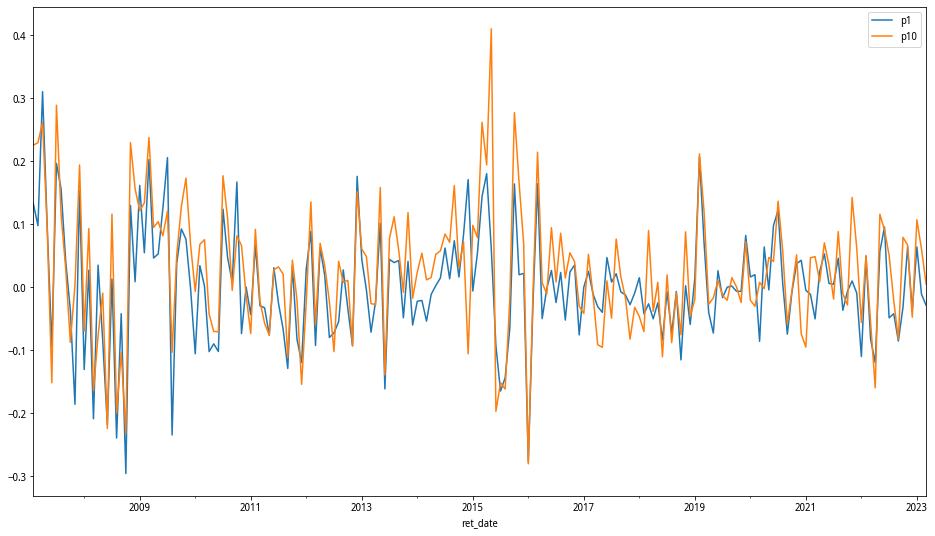

In [63]:
pd.DataFrame(portfolios_crs_mean)[['p1','p10']].plot()

## Double sort

In [64]:
ret_df.rename(columns={'illiq_1m':'illiq'},inplace=True)

In [65]:
from myutils.factor_func import double_sort, factor, daily_factor

In [66]:
double_sort?

Signature:
double_sort(
    df,
    sort1,
    sort2='size',
    group_date='ym',
    merge_cols=['secID', 'ret_date'],
)
Docstring:
Double sorting. 
Arguments:
    sort1: variable 1 for sorting into 3 groups
    sort2: default is "size", sorting into 2 groups
    group_date: the dates upon which the factor exposures are sorted
    merge_cols: the columns
returns:
    portfolios containing 2*3 groups
File:      /srv/data/notes_py3/myutils/factor_func.py
Type:      function


In [67]:
portfolios = double_sort(ret_df, sort1='illiq')

In [68]:
portfolios

{'illiq1_size1':              secID ret_date       ym       ret     exret       size  \
 0      002051.XSHE  2007-07  2007-06  0.084480  0.081998  21.146571   
 1      600178.XSHG  2007-07  2007-06  0.171246  0.168765  21.249828   
 2      600578.XSHG  2007-07  2007-06  0.165449  0.162967  21.225388   
 3      601008.XSHG  2007-07  2007-06 -0.004110 -0.006591  21.284024   
 4      000514.XSHE  2007-08  2007-07 -0.124571 -0.126974  21.262089   
 5      000565.XSHE  2007-08  2007-07 -0.107408 -0.109812  21.390840   
 6      600116.XSHG  2007-08  2007-07 -0.022585 -0.024988  20.899163   
 7      600199.XSHG  2007-08  2007-07 -0.076652 -0.079056  21.460322   
 ...            ...      ...      ...       ...       ...        ...   
 15009  600178.XSHG  2007-05  2007-04  0.043615  0.041088  21.335549   
 15010  600227.XSHG  2007-05  2007-04  0.065150  0.062623  21.249363   
 15011  600303.XSHG  2007-05  2007-04  0.118673  0.116146  21.231079   
 15012  600377.XSHG  2007-05  2007-04  0.054804 

In [69]:
mean_portfolios_ret = dict()
for pf in portfolios.keys():
    mean_portfolios_ret[pf] = portfolios[pf].groupby('ret_date')['exret'].mean()
#     print(mean_portfolios_ret[pf].shape) # print 看一下会不会存在某个月份上没有illiq和size分组没有任何交叉

# Fast merge by stacking
mean_portfolios_ret_df = pd.DataFrame(np.vstack([pf for pf in mean_portfolios_ret.values()])).T
mean_portfolios_ret_df.columns = mean_portfolios_ret.keys()
mean_portfolios_ret_df.index = mean_portfolios_ret['illiq1_size1'].index

# Newey-West adjustment
mean_values = {}
t_values = {}
for k in mean_portfolios_ret.keys():
    y = mean_portfolios_ret[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=4)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

illiq1_size1  illiq1_size2  illiq2_size1  illiq2_size2  \
ret_mean     -0.008295      0.004311      0.012162      0.010906   
t_values     -1.115058      0.589066      1.594451      1.523416   

          illiq3_size1  illiq3_size2  
ret_mean      0.022977      0.011425  
t_values      2.885358      1.651777

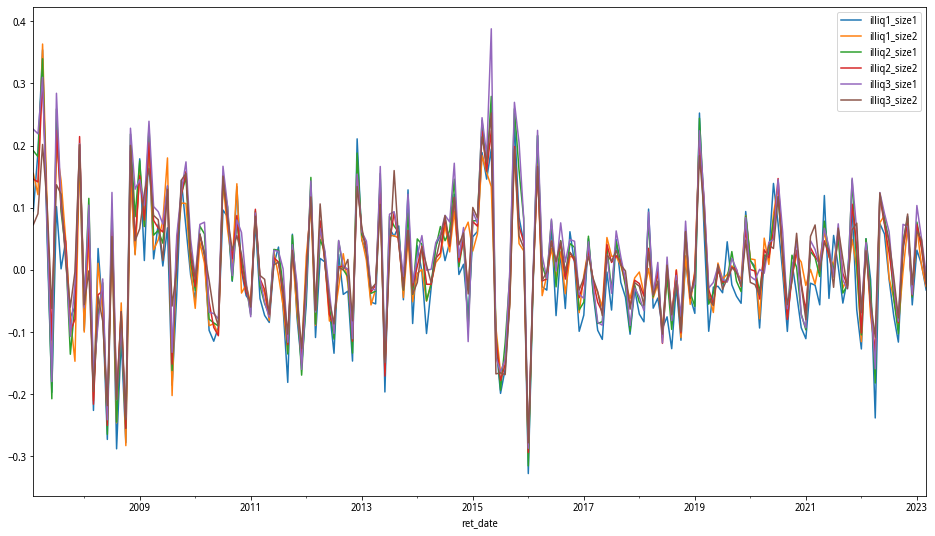

In [70]:
mean_portfolios_ret_df.plot()

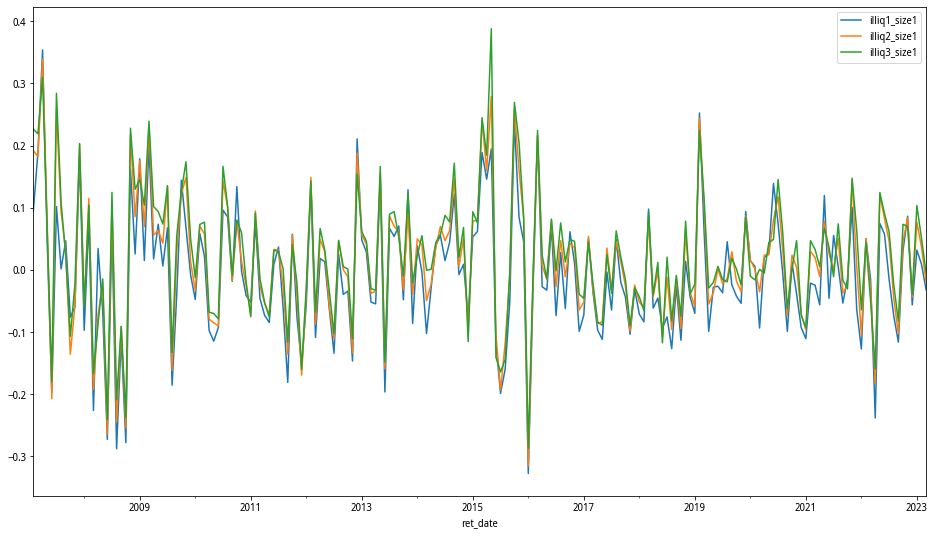

In [71]:
# Within mktcap1, any difference in illiq groups?
pfs = mean_portfolios_ret_df.columns
cols = list(pfs[pfs.str[-5:] == 'size1'])
mean_portfolios_ret_df[cols].plot()

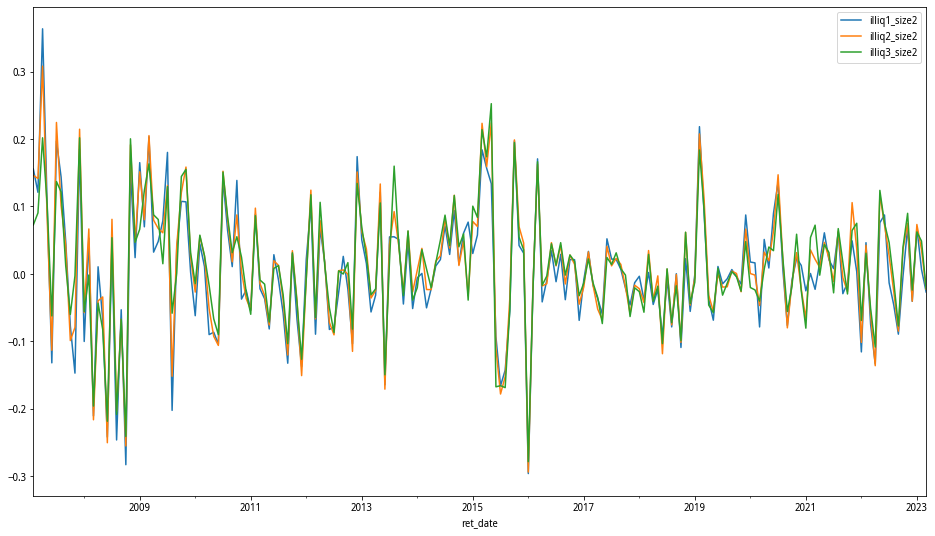

In [72]:
# Within mktcap1, any difference in illiq groups?
pfs = mean_portfolios_ret_df.columns
cols = list(pfs[pfs.str[-5:] == 'size2'])
mean_portfolios_ret_df[cols].plot()

## FM regression

In [73]:
def fm_reg(df,cols):
    df_  = df.dropna()
    if df_.shape[0] < 15:
        return [None]*(len(cols)+1)
    reg = LinearRegression(fit_intercept=True).fit(y=df_.loc[:,'exret'], X=df_.loc[:,cols])
    return np.insert(reg.coef_, 0, reg.intercept_)

In [74]:
cols = ['illiq']
temp = ret_df.groupby('ret_date').apply(fm_reg, cols=cols)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept'] + cols
reg_result_df.dropna(inplace=True)
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

intercept     illiq
ret_mean   0.003120  7.760135
t_values   0.444807  2.270793

In [75]:
cols = ['beta','size','bm','mom','rev','illiq']
temp = ret_df.groupby('ret_date').apply(fm_reg, cols=cols)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept'] + cols
reg_result_df.dropna(inplace=True)
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

intercept      beta      size        bm       mom       rev  \
ret_mean   0.054002  0.000861 -0.002522  0.006947 -0.001354 -0.048696   
t_values   1.578889  0.201770 -1.846297  1.574099 -0.487488 -6.080879   

              illiq  
ret_mean  11.314545  
t_values   5.734962

# Illiquidity factor

### Long-short factor

In [76]:
illiq_df = factor(ret_df, sort1='illiq', long_only=False)

In [77]:
illiq_df

ret_date
2007-02    0.056261
2007-03   -0.003323
2007-04   -0.070730
2007-05    0.021364
2007-06    0.014134
2007-07    0.081977
2007-08    0.021051
2007-09   -0.016609
             ...   
2022-08    0.026123
2022-09    0.011383
2022-10    0.071406
2022-11    0.000639
2022-12   -0.000574
2023-01    0.032463
2023-02    0.045714
2023-03    0.013842
Freq: M, Name: illiq, Length: 194, dtype: float64

In [78]:
factors_df = pd.read_pickle('./output_data/factors/ff3_rev.pkl')

In [79]:
factors_df.index = factors_df.index.to_period('M')

In [80]:
factors_df = pd.merge(factors_df,illiq_df,on='ret_date')

In [81]:
factors_df

exmktret       SMB       HML       rev     illiq
ret_date                                                  
2008-02   0.024010  0.081818  0.008108 -0.008338  0.002133
2008-03  -0.195480  0.015385 -0.026179  0.028419  0.024245
2008-04   0.022519 -0.114571  0.025498  0.085967 -0.113652
2008-05  -0.080798  0.065998 -0.005976  0.026575  0.017733
2008-06  -0.236014 -0.031857 -0.002291 -0.018611  0.028636
2008-07   0.014972  0.090812  0.013375  0.062681  0.045922
2008-08  -0.170063 -0.067974  0.027218  0.003875  0.017148
2008-09  -0.067913 -0.035740  0.031455  0.038336  0.020006
...            ...       ...       ...       ...       ...
2022-07  -0.060974  0.080640  0.002318  0.006018  0.081947
2022-08  -0.023276 -0.016549  0.034316  0.053570  0.026123
2022-09  -0.069642 -0.028932  0.014421 -0.021165  0.011383
2022-10  -0.056037  0.095840 -0.007235  0.047340  0.071406
2022-11   0.086374 -0.010996  0.041022  0.106961  0.000639
2022-12  -0.010731 -0.020749 -0.022789 -0.028555 -0.000574
2023-01   0.071339  0.022442 -0.005458  0.060233  0.032463
2023-02  -0.014930  0.035220  0.014046  0.011373  0.045714

[181 rows x 5 columns]

In [82]:
rf_df = ret_df[['ret_date','rf']].drop_duplicates().sort_values('ret_date').dropna()

In [83]:
factors_df = pd.merge(rf_df,factors_df,on='ret_date').set_index('ret_date')

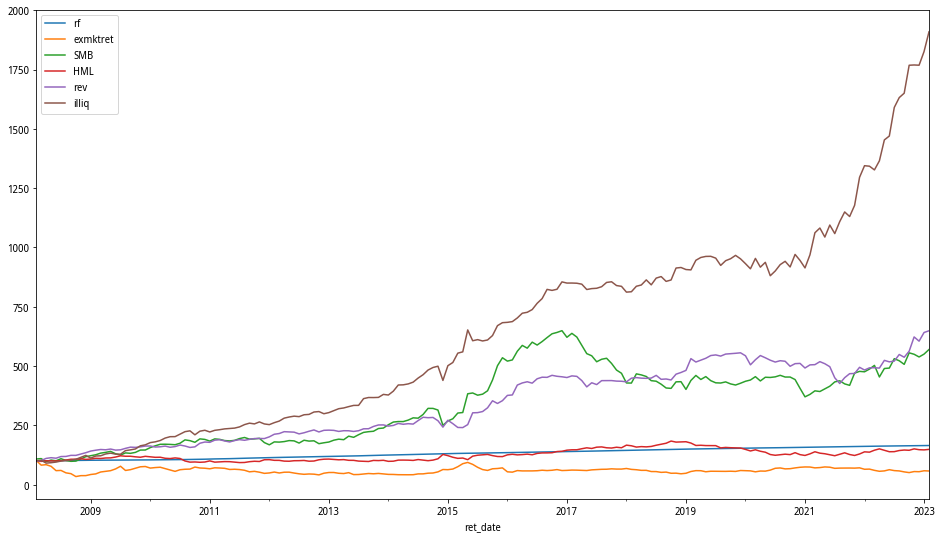

In [84]:
((factors_df+1).cumprod()*100).plot()

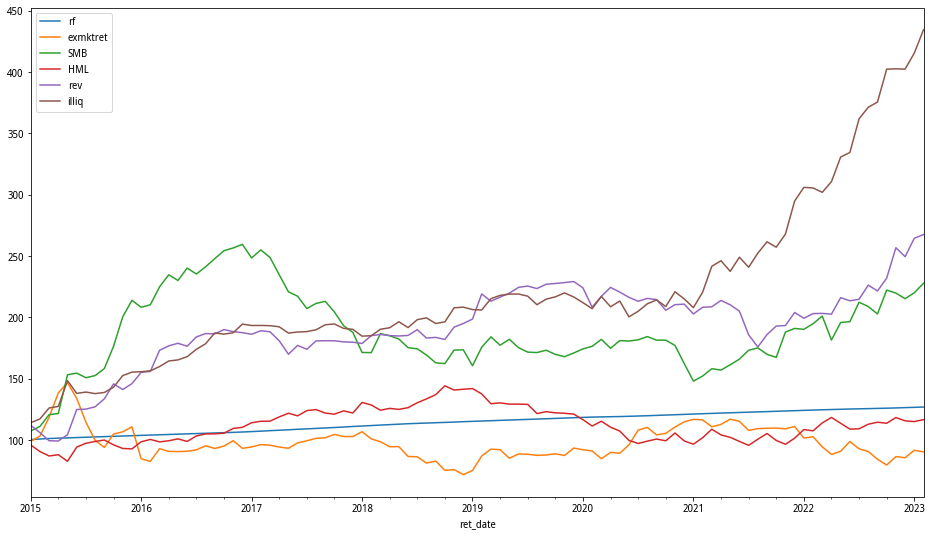

In [85]:
((factors_df['2015':]+1).cumprod()*100).plot()

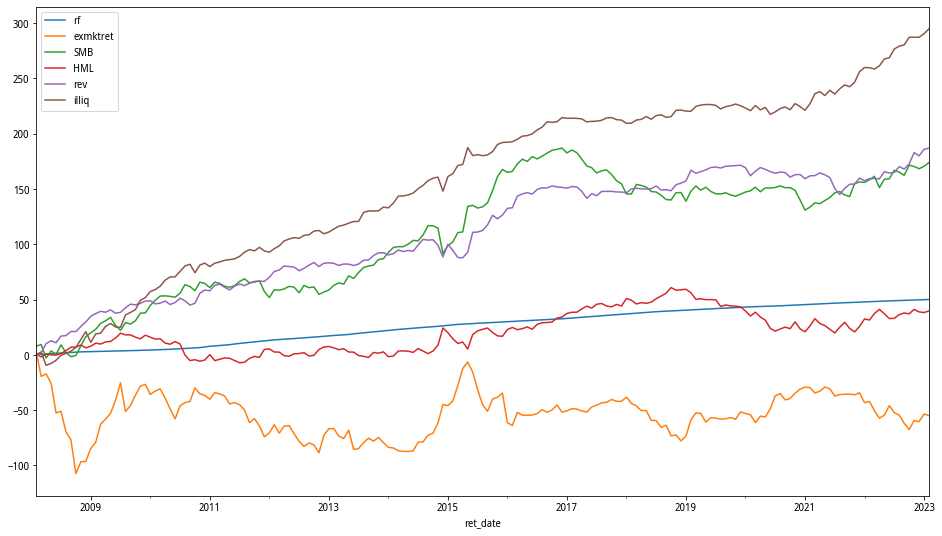

In [86]:
(np.log(1 + factors_df).cumsum()*100).plot()

### Long-only factor

In [87]:
illiq_long_df = factor(ret_df, sort1='illiq')

In [88]:
illiq_long_df

ret_date
2007-02    0.147877
2007-03    0.145453
2007-04    0.257292
2007-05    0.089519
2007-06   -0.120417
2007-07    0.228057
2007-08    0.114996
2007-09    0.028461
             ...   
2022-08   -0.017149
2022-09   -0.076478
2022-10    0.054459
2022-11    0.085286
2022-12   -0.031697
2023-01    0.081029
2023-02    0.048121
2023-03   -0.012103
Freq: M, Name: illiq, Length: 194, dtype: float64

In [89]:
factors_long_df = pd.read_pickle('./output_data/factors/ff3_rev_long_only.pkl')

In [90]:
factors_long_df.index = factors_long_df.index.to_period('M')

In [91]:
factors_long_df = pd.merge(factors_long_df,illiq_long_df,on='ret_date')

In [92]:
factors_long_df = pd.merge(rf_df,factors_long_df,on='ret_date').set_index('ret_date')

In [93]:
factors_long_df.rename(columns={'illiq':'illiq_long'},inplace=True)

In [94]:
factors_long_df

rf  exmktret  small_only  high_only  rev_long  illiq_long
ret_date                                                                 
2008-02   0.002946  0.024010    0.103117   0.059319  0.061518    0.054128
2008-03   0.002746 -0.195480   -0.180562  -0.202495 -0.167375   -0.180816
2008-04   0.002862  0.022519   -0.073326  -0.010688  0.024523   -0.063553
2008-05   0.002953 -0.080798   -0.020022  -0.056407 -0.041619   -0.061992
2008-06   0.003113 -0.236014   -0.257252  -0.239010 -0.249352   -0.218804
2008-07   0.002806  0.014972    0.108774   0.072304  0.086448    0.084925
2008-08   0.002681 -0.170063   -0.232768  -0.187431 -0.203679   -0.206455
2008-09   0.002889 -0.067913   -0.089285  -0.068049 -0.062323   -0.065761
...            ...       ...         ...        ...       ...         ...
2022-07   0.001448 -0.060974    0.047271   0.002560  0.015416    0.053249
2022-08   0.001251 -0.023276   -0.034803  -0.009445 -0.010168   -0.017149
2022-09   0.001426 -0.069642   -0.092335  -0.068136 -0.091581   -0.076478
2022-10   0.001400 -0.056037    0.053699  -0.005541  0.025716    0.054459
2022-11   0.001596  0.086374    0.078566   0.103273  0.126171    0.085286
2022-12   0.001955 -0.010731   -0.041613  -0.040295 -0.043517   -0.031697
2023-01   0.001856  0.071339    0.082598   0.065335  0.097496    0.081029
2023-02   0.001910 -0.014930    0.038597   0.020645  0.020647    0.048121

[181 rows x 6 columns]

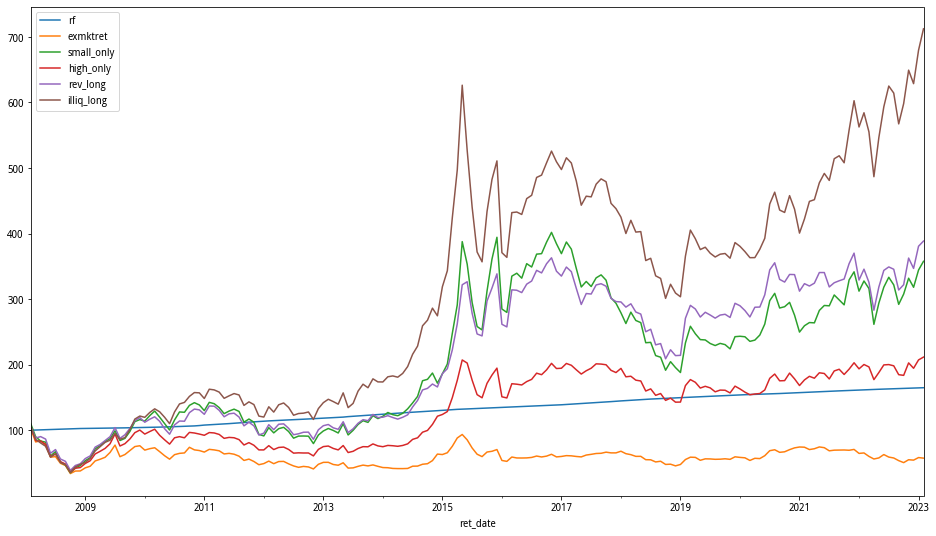

In [95]:
((factors_long_df+1).cumprod()*100).plot()

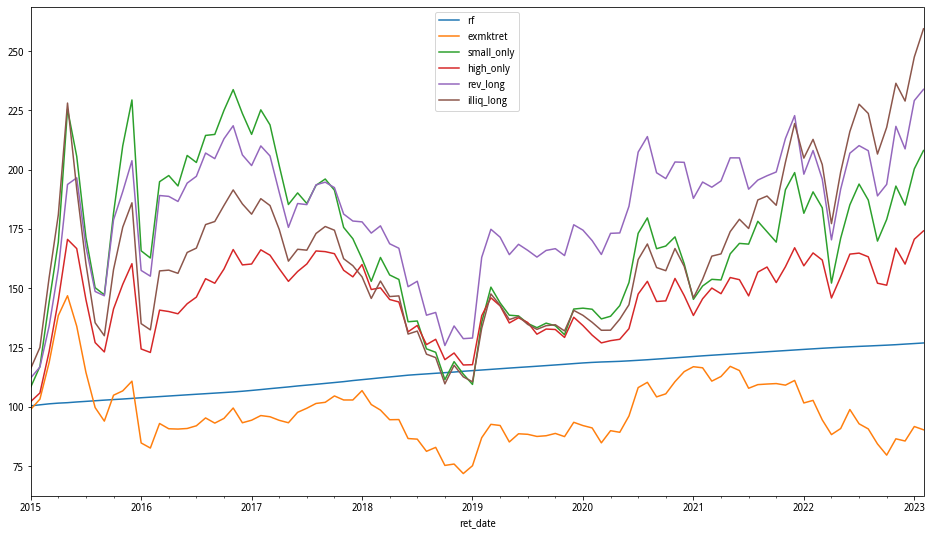

In [96]:
((1 + factors_long_df['2015':]).cumprod()*100).plot()

# Volality

## Raw volatility

In [97]:
stk_df

secID  tradeDate  preClosePrice  closePrice  negMarketValue  \
0         000001.XSHE 2007-06-20        824.193     987.007    4.835036e+10   
1         000001.XSHE 2007-06-21        987.007    1085.740    5.318694e+10   
2         000001.XSHE 2007-06-22       1085.740    1120.233    5.487665e+10   
3         000001.XSHE 2007-06-25       1120.233    1113.904    5.456661e+10   
4         000001.XSHE 2007-06-26       1113.904    1113.904    5.456661e+10   
5         000001.XSHE 2007-06-27       1113.904    1019.602    4.994705e+10   
6         000001.XSHE 2007-06-28       1019.602     953.780    4.672266e+10   
7         000001.XSHE 2007-06-29        953.780     870.870    4.266117e+10   
...               ...        ...            ...         ...             ...   
10996475  689009.XSHG 2023-03-01         33.000      33.540    1.716242e+10   
10996476  689009.XSHG 2023-03-02         33.540      34.540    1.767412e+10   
10996477  689009.XSHG 2023-03-03         34.540      34.570    1.768947e+10   
10996478  689009.XSHG 2023-03-06         34.570      33.890    1.734151e+10   
10996479  689009.XSHG 2023-03-07         33.890      33.370    1.707543e+10   
10996480  689009.XSHG 2023-03-08         33.370      34.080    1.743874e+10   
10996481  689009.XSHG 2023-03-09         34.080      33.410    1.709590e+10   
10996482  689009.XSHG 2023-03-10         33.410      32.610    1.668654e+10   

          turnoverValue  turnoverRate  ret_daily   illiq_daily       ym  \
0          4.182345e+09        0.0840   0.197544  4.723272e-11  2007-06   
1          2.285485e+09        0.0440   0.100033  4.376871e-11  2007-06   
2          2.761567e+09        0.0510   0.031769  1.150402e-11  2007-06   
3          2.324186e+09        0.0426  -0.005650  2.430837e-12  2007-06   
4          0.000000e+00        0.0000   0.000000           NaN  2007-06   
5          2.446556e+09        0.0489  -0.084659  3.460334e-11  2007-06   
6          1.617434e+09        0.0336  -0.064557  3.991295e-11  2007-06   
7          1.410758e+09        0.0316  -0.086928  6.161781e-11  2007-06   
...                 ...           ...        ...           ...      ...   
10996475   1.944676e+08        0.0113   0.016364  8.414582e-11  2023-03   
10996476   2.680590e+08        0.0152   0.029815  1.112261e-10  2023-03   
10996477   1.751267e+08        0.0099   0.000869  4.959600e-12  2023-03   
10996478   1.447322e+08        0.0083  -0.019670  1.359078e-10  2023-03   
10996479   1.540738e+08        0.0089  -0.015344  9.958710e-11  2023-03   
10996480   1.229896e+08        0.0071   0.021277  1.729950e-10  2023-03   
10996481   1.240722e+08        0.0072  -0.019660  1.584531e-10  2023-03   
10996482   1.129391e+08        0.0068  -0.023945  2.120162e-10  2023-03   

            illiq_250d  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
5                  NaN  
6                  NaN  
7                  NaN  
...                ...  
10996475  2.018422e-10  
10996476  2.019120e-10  
10996477  2.018799e-10  
10996478  2.014028e-10  
10996479  2.012732e-10  
10996480  2.012109e-10  
10996481  2.015143e-10  
10996482  2.012681e-10  

[10996483 rows x 11 columns]

In [98]:
vol_df = stk_df.groupby(['secID','ym'])['ret_daily'].std()

In [99]:
vol_df

secID        ym     
000001.XSHE  2007-06    0.098564
             2007-07    0.041604
             2007-08    0.033926
             2007-09    0.023872
             2007-10    0.035921
             2007-11    0.033184
             2007-12    0.026541
             2008-01    0.037722
                          ...   
689009.XSHG  2022-08    0.038345
             2022-09    0.020987
             2022-10    0.059961
             2022-11    0.017044
             2022-12    0.019017
             2023-01    0.014183
             2023-02    0.024867
             2023-03    0.021311
Name: ret_daily, Length: 548447, dtype: float64

In [100]:
vol_df = vol_df.to_frame()

In [101]:
vol_df.columns = ['vol']
vol_df.reset_index(inplace=True)

MIN_NOBS = 15
idx = stk_df.groupby(['secID','ym'],as_index=False)['tradeDate'].count()['tradeDate'] < MIN_NOBS

vol_df.loc[idx, 'vol'] = np.nan

In [102]:
vol_df

secID       ym       vol
0       000001.XSHE  2007-06       NaN
1       000001.XSHE  2007-07  0.041604
2       000001.XSHE  2007-08  0.033926
3       000001.XSHE  2007-09  0.023872
4       000001.XSHE  2007-10  0.035921
5       000001.XSHE  2007-11  0.033184
6       000001.XSHE  2007-12  0.026541
7       000001.XSHE  2008-01  0.037722
...             ...      ...       ...
548439  689009.XSHG  2022-08  0.038345
548440  689009.XSHG  2022-09  0.020987
548441  689009.XSHG  2022-10  0.059961
548442  689009.XSHG  2022-11  0.017044
548443  689009.XSHG  2022-12  0.019017
548444  689009.XSHG  2023-01  0.014183
548445  689009.XSHG  2023-02  0.024867
548446  689009.XSHG  2023-03       NaN

[548447 rows x 3 columns]

下部分需要用到日度因子收益率，先运行 5-factors.ipynb

## Idiosyncratic volatility

Idiosyncratic volatility 指的是被已有的因子收益率回归之后，剩下的残差的波动率。传统金融理论认为残差部分属于可分散的风险，不应该被定价。即使认为因子模型还不够好，残差部分有剩余未被解释的系统性风险的部分，这部分的风险溢价(factor risk premium)也应该是正的。然而，美国市场的数据发现，波动率越低，未来的收益越高。这是一个很有意思的异象。

最广为人知的文献是 Ang, Hodrick, Xing, and Zhang (2006)。

- Bali and Cakici (2008): 数据处理的细节对结果影响很大，包括数据频率、portfolio加权的方式、分位点的计算等等
- Huang et al. (2010 RFS): 这个异象和 reversal 有关
- 其他部分文献：Han and Lesmond (2011), Bali, Cakici, and Whitelaw (2011), Baker, Bradley, and Wurgler (2011), Baker and Wurgler (2014)

我们每个月用因子模型计算一下ivol，用来排序。

#### Daily factors

In [103]:
pd.read_pickle('./output_data/factors/factors_daily.pkl')

rf  exmktret      size        bm       mom       rev
tradeDate                                                             
2007-02-01  0.000048  0.005542  0.002193  0.007141       NaN       NaN
2007-02-02  0.000048 -0.035335  0.018346  0.010887       NaN       NaN
2007-02-05  0.000048 -0.005993  0.019852  0.009071       NaN       NaN
2007-02-06  0.000049  0.019879  0.006771  0.005678       NaN       NaN
2007-02-07  0.000050  0.021923 -0.007161 -0.004263       NaN       NaN
2007-02-08  0.000052  0.017380 -0.000822  0.004951       NaN       NaN
2007-02-09  0.000076 -0.003355  0.003797  0.001221       NaN       NaN
2007-02-12  0.000110  0.033455 -0.009410 -0.005880       NaN       NaN
...              ...       ...       ...       ...       ...       ...
2023-03-01  0.000057  0.012218 -0.001004  0.002296 -0.005329 -0.003995
2023-03-02  0.000044 -0.002502 -0.002209  0.008971 -0.002233 -0.006793
2023-03-03  0.000035  0.002599 -0.004169  0.006088  0.001806  0.004329
2023-03-06  0.000034 -0.003703  0.003056 -0.007538  0.004599  0.000788
2023-03-07  0.000039 -0.015381 -0.008653  0.007773  0.005362  0.003633
2023-03-08  0.000045 -0.002034  0.012430 -0.000479 -0.007435 -0.006697
2023-03-09  0.000038 -0.003295  0.006774  0.000205 -0.007228 -0.001795
2023-03-10  0.000050 -0.013107  0.000548 -0.005310 -0.003413  0.002104

[3915 rows x 6 columns]

In [104]:
shibor1d = DataAPI.MktIborGet(secID="Shibor1D.IRCN",beginDate=START,endDate=END,field=['tradeDate','rate'],pandas="1")
shibor1d['tradeDate'] = pd.to_datetime(shibor1d['tradeDate'])
shibor1d['rate'] = shibor1d['rate'] * 0.01 / 365
shibor1d.rename(columns={'rate':'rf'},inplace=True)

In [105]:
factors_daily = pd.read_pickle('./output_data/factors/factors_daily.pkl')

In [106]:
illiq_daily = daily_factor(ret_df, stock_df=stk_df,sort1='illiq',long_only=False)

In [107]:
illiq_daily

tradeDate
2007-02-01    0.007441
2007-02-02    0.021398
2007-02-05    0.014869
2007-02-06   -0.011942
2007-02-07   -0.003747
2007-02-08    0.011539
2007-02-09    0.004863
2007-02-12   -0.003945
                ...   
2023-03-01   -0.005766
2023-03-02    0.003941
2023-03-03   -0.003889
2023-03-06    0.008524
2023-03-07   -0.001184
2023-03-08    0.004348
2023-03-09    0.006847
2023-03-10    0.001172
Name: illiq, Length: 3915, dtype: float64

In [108]:
illiq_daily.name = 'illiq'

In [109]:
factors_daily = pd.merge(factors_daily, illiq_daily, on='tradeDate')

In [110]:
factors_daily

rf  exmktret      size        bm       mom       rev  \
tradeDate                                                                
2007-02-01  0.000048  0.005542  0.002193  0.007141       NaN       NaN   
2007-02-02  0.000048 -0.035335  0.018346  0.010887       NaN       NaN   
2007-02-05  0.000048 -0.005993  0.019852  0.009071       NaN       NaN   
2007-02-06  0.000049  0.019879  0.006771  0.005678       NaN       NaN   
2007-02-07  0.000050  0.021923 -0.007161 -0.004263       NaN       NaN   
2007-02-08  0.000052  0.017380 -0.000822  0.004951       NaN       NaN   
2007-02-09  0.000076 -0.003355  0.003797  0.001221       NaN       NaN   
2007-02-12  0.000110  0.033455 -0.009410 -0.005880       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2023-03-01  0.000057  0.012218 -0.001004  0.002296 -0.005329 -0.003995   
2023-03-02  0.000044 -0.002502 -0.002209  0.008971 -0.002233 -0.006793   
2023-03-03  0.000035  0.002599 -0.004169  0.006088  0.001806  0.004329   
2023-03-06  0.000034 -0.003703  0.003056 -0.007538  0.004599  0.000788   
2023-03-07  0.000039 -0.015381 -0.008653  0.007773  0.005362  0.003633   
2023-03-08  0.000045 -0.002034  0.012430 -0.000479 -0.007435 -0.006697   
2023-03-09  0.000038 -0.003295  0.006774  0.000205 -0.007228 -0.001795   
2023-03-10  0.000050 -0.013107  0.000548 -0.005310 -0.003413  0.002104   

               illiq  
tradeDate             
2007-02-01  0.007441  
2007-02-02  0.021398  
2007-02-05  0.014869  
2007-02-06 -0.011942  
2007-02-07 -0.003747  
2007-02-08  0.011539  
2007-02-09  0.004863  
2007-02-12 -0.003945  
...              ...  
2023-03-01 -0.005766  
2023-03-02  0.003941  
2023-03-03 -0.003889  
2023-03-06  0.008524  
2023-03-07 -0.001184  
2023-03-08  0.004348  
2023-03-09  0.006847  
2023-03-10  0.001172  

[3915 rows x 7 columns]

#### 计算月度的 idiosyncratic volatility

In [111]:
def idiovol_np(df, factor_cols, len_periods='1m', min_nobs=15):
    """
    df: year_month is set as index
    """
    year_months = df.index.unique()
    n = len(year_months)
    idiovol = np.full(shape=n, fill_value=np.nan)
    start_notnan_month = int(len_periods[:-1])-1
    for i in range(start_notnan_month,n):
        df_ = df.loc[str(year_months[i]-int(len_periods[:-1])+1) : str(year_months[i]),['exret']+factor_cols].dropna().to_numpy()
        if len(df_) < min_nobs:
            continue
        else:
            y_ = df_[:,0] # 
            X_ = df_[:,1:]
            reg = LinearRegression().fit(y=y_, X=X_)
            res = y_ - reg.predict(X_)
            idiovol[i] = np.std(res)
    idiovol_df = pd.DataFrame({'ym': year_months, f'idiovol{len_periods}': idiovol})
    return idiovol_df

In [112]:
def idiovol(df,factor_cols,min_nobs=15):
    df = df.dropna()
    y = df.loc[:,'exret']
    X = df.loc[:,factor_cols]
    nobs = len(X)
    if nobs < min_nobs:
        idiovol = np.nan
    else:
        reg = LinearRegression().fit(y=y,X=X)
        res = y - reg.predict(X)
        idiovol = np.std(res)
    return idiovol

In [113]:
reg_df = pd.merge(stk_df[['secID','tradeDate','ret_daily']],factors_daily,
                  on=['tradeDate'])

In [114]:
reg_df

secID  tradeDate  ret_daily        rf  exmktret      size  \
0         000001.XSHE 2007-06-20   0.197544  0.000073 -0.024256 -0.003004   
1         000002.XSHE 2007-06-20  -0.035577  0.000073 -0.024256 -0.003004   
2         000006.XSHE 2007-06-20  -0.030451  0.000073 -0.024256 -0.003004   
3         000007.XSHE 2007-06-20        NaN  0.000073 -0.024256 -0.003004   
4         000008.XSHE 2007-06-20        NaN  0.000073 -0.024256 -0.003004   
5         000012.XSHE 2007-06-20  -0.066159  0.000073 -0.024256 -0.003004   
6         000014.XSHE 2007-06-20  -0.002394  0.000073 -0.024256 -0.003004   
7         000016.XSHE 2007-06-20  -0.050821  0.000073 -0.024256 -0.003004   
...               ...        ...        ...       ...       ...       ...   
10972943  601607.XSHG 2007-06-19   0.100267  0.000071  0.009520  0.008822   
10972944  601628.XSHG 2007-06-19  -0.018618  0.000071  0.009520  0.008822   
10972945  601666.XSHG 2007-06-19  -0.003302  0.000071  0.009520  0.008822   
10972946  601699.XSHG 2007-06-19   0.043605  0.000071  0.009520  0.008822   
10972947  601872.XSHG 2007-06-19   0.099859  0.000071  0.009520  0.008822   
10972948  601988.XSHG 2007-06-19  -0.001866  0.000071  0.009520  0.008822   
10972949  601991.XSHG 2007-06-19   0.100027  0.000071  0.009520  0.008822   
10972950  601998.XSHG 2007-06-19  -0.012695  0.000071  0.009520  0.008822   

                bm  mom       rev     illiq  
0        -0.000760  NaN -0.001559  0.000541  
1        -0.000760  NaN -0.001559  0.000541  
2        -0.000760  NaN -0.001559  0.000541  
3        -0.000760  NaN -0.001559  0.000541  
4        -0.000760  NaN -0.001559  0.000541  
5        -0.000760  NaN -0.001559  0.000541  
6        -0.000760  NaN -0.001559  0.000541  
7        -0.000760  NaN -0.001559  0.000541  
...            ...  ...       ...       ...  
10972943  0.004264  NaN  0.000622 -0.009446  
10972944  0.004264  NaN  0.000622 -0.009446  
10972945  0.004264  NaN  0.000622 -0.009446  
10972946  0.004264  NaN  0.000622 -0.009446  
10972947  0.004264  NaN  0.000622 -0.009446  
10972948  0.004264  NaN  0.000622 -0.009446  
10972949  0.004264  NaN  0.000622 -0.009446  
10972950  0.004264  NaN  0.000622 -0.009446  

[10972951 rows x 10 columns]

In [115]:
reg_df.sort_values(['secID','tradeDate'],inplace=True)

In [116]:
reg_df

secID  tradeDate  ret_daily        rf  exmktret      size  \
0         000001.XSHE 2007-06-20   0.197544  0.000073 -0.024256 -0.003004   
1290      000001.XSHE 2007-06-21   0.100033  0.000064  0.005827 -0.009497   
2580      000001.XSHE 2007-06-22   0.031769  0.000058 -0.040473 -0.017067   
3870      000001.XSHE 2007-06-25  -0.005650  0.000052 -0.048566 -0.018312   
5160      000001.XSHE 2007-06-26   0.000000  0.000049  0.014660 -0.000199   
6451      000001.XSHE 2007-06-27  -0.084659  0.000047  0.027391 -0.002727   
7742      000001.XSHE 2007-06-28  -0.064557  0.000046 -0.050035 -0.022209   
9033      000001.XSHE 2007-06-29  -0.086928  0.000049 -0.029572 -0.016960   
...               ...        ...        ...       ...       ...       ...   
10828509  689009.XSHG 2023-03-01   0.016364  0.000057  0.012218 -0.001004   
10833303  689009.XSHG 2023-03-02   0.029815  0.000044 -0.002502 -0.002209   
10838099  689009.XSHG 2023-03-03   0.000869  0.000035  0.002599 -0.004169   
10842896  689009.XSHG 2023-03-06  -0.019670  0.000034 -0.003703  0.003056   
10847694  689009.XSHG 2023-03-07  -0.015344  0.000039 -0.015381 -0.008653   
10852493  689009.XSHG 2023-03-08   0.021277  0.000045 -0.002034  0.012430   
10857294  689009.XSHG 2023-03-09  -0.019660  0.000038 -0.003295  0.006774   
10862096  689009.XSHG 2023-03-10  -0.023945  0.000050 -0.013107  0.000548   

                bm       mom       rev     illiq  
0        -0.000760       NaN -0.001559  0.000541  
1290      0.001252       NaN  0.007577 -0.008228  
2580     -0.012254       NaN -0.005417  0.009722  
3870     -0.014716       NaN -0.004875  0.004986  
5160      0.014121       NaN  0.009540  0.002795  
6451     -0.007487       NaN -0.005338 -0.002271  
7742     -0.000901       NaN  0.002548  0.002782  
9033      0.005592       NaN  0.001984 -0.000487  
...            ...       ...       ...       ...  
10828509  0.002296 -0.005329 -0.003995 -0.005766  
10833303  0.008971 -0.002233 -0.006793  0.003941  
10838099  0.006088  0.001806  0.004329 -0.003889  
10842896 -0.007538  0.004599  0.000788  0.008524  
10847694  0.007773  0.005362  0.003633 -0.001184  
10852493 -0.000479 -0.007435 -0.006697  0.004348  
10857294  0.000205 -0.007228 -0.001795  0.006847  
10862096 -0.005310 -0.003413  0.002104  0.001172  

[10972951 rows x 10 columns]

In [117]:
reg_df['exret'] = reg_df['ret_daily'] - reg_df['rf']

In [118]:
reg_df['ym'] = reg_df['tradeDate'].dt.to_period('M')

#### 代码测试

In [119]:
# Testing the time consuming 
ids = reg_df['secID'].unique()
ids_ = np.random.choice(ids, 50)
temp = reg_df[reg_df['secID'].isin(ids_)]

In [120]:
temp.set_index('ym',inplace=True)

In [121]:
temp

secID  tradeDate  ret_daily        rf  exmktret      size  \
ym                                                                         
2013-05  000633.XSHE 2013-05-13  -0.055121  0.000059 -0.002170  0.008019   
2013-05  000633.XSHE 2013-05-14   0.026392  0.000061 -0.014068  0.003176   
2013-05  000633.XSHE 2013-05-15  -0.041944  0.000061  0.007328  0.006982   
2013-05  000633.XSHE 2013-05-16  -0.001417  0.000074  0.016359 -0.007533   
2013-05  000633.XSHE 2013-05-17  -0.004256  0.000078  0.015307 -0.001542   
2013-05  000633.XSHE 2013-05-20   0.011378  0.000081  0.008092  0.009607   
2013-05  000633.XSHE 2013-05-21  -0.008433  0.000092  0.004636  0.008285   
2013-05  000633.XSHE 2013-05-22   0.008504  0.000094 -0.001194 -0.007685   
...              ...        ...        ...       ...       ...       ...   
2023-03  688448.XSHG 2023-03-01   0.014155  0.000057  0.012218 -0.001004   
2023-03  688448.XSHG 2023-03-02  -0.003395  0.000044 -0.002502 -0.002209   
2023-03  688448.XSHG 2023-03-03  -0.005299  0.000035  0.002599 -0.004169   
2023-03  688448.XSHG 2023-03-06   0.006849  0.000034 -0.003703  0.003056   
2023-03  688448.XSHG 2023-03-07  -0.017007  0.000039 -0.015381 -0.008653   
2023-03  688448.XSHG 2023-03-08   0.041138  0.000045 -0.002034  0.012430   
2023-03  688448.XSHG 2023-03-09   0.007755  0.000038 -0.003295  0.006774   
2023-03  688448.XSHG 2023-03-10   0.000733  0.000050 -0.013107  0.000548   

               bm       mom       rev     illiq     exret  
ym                                                         
2013-05 -0.003581  0.002963 -0.000166 -0.001310 -0.055180  
2013-05  0.001602 -0.000817 -0.000833  0.002965  0.026330  
2013-05 -0.007121  0.005208 -0.001819 -0.002645 -0.042006  
2013-05  0.002838 -0.001341 -0.001790 -0.001110 -0.001491  
2013-05 -0.000030 -0.002595 -0.000057 -0.000209 -0.004334  
2013-05  0.000196  0.001505  0.000002  0.002296  0.011297  
2013-05 -0.005164 -0.000513 -0.001766 -0.001181 -0.008525  
2013-05  0.002097 -0.007481  0.001874 -0.000339  0.008411  
...           ...       ...       ...       ...       ...  
2023-03  0.002296 -0.005329 -0.003995 -0.005766  0.014097  
2023-03  0.008971 -0.002233 -0.006793  0.003941 -0.003439  
2023-03  0.006088  0.001806  0.004329 -0.003889 -0.005334  
2023-03 -0.007538  0.004599  0.000788  0.008524  0.006816  
2023-03  0.007773  0.005362  0.003633 -0.001184 -0.017046  
2023-03 -0.000479 -0.007435 -0.006697  0.004348  0.041093  
2023-03  0.000205 -0.007228 -0.001795  0.006847  0.007717  
2023-03 -0.005310 -0.003413  0.002104  0.001172  0.000683  

[98701 rows x 11 columns]

In [122]:
%%time
result1 = temp.groupby(['secID','ym']).apply(idiovol, factor_cols=['exmktret','size','bm','mom','rev','illiq'])

CPU times: user 19.9 s, sys: 112 ms, total: 20 s
Wall time: 20 s


In [123]:
%%time
result2 = temp.groupby(['secID']).apply(idiovol_np, factor_cols=['exmktret','size','bm','mom','rev','illiq'])

CPU times: user 16 s, sys: 296 ms, total: 16.3 s
Wall time: 16.3 s


In [124]:
result1

secID        ym     
000633.XSHE  2013-05    0.014769
             2013-06    0.018697
             2013-07    0.013132
             2013-08    0.017645
             2013-09    0.011311
             2013-10    0.017895
             2013-11    0.005897
             2013-12    0.013490
                          ...   
688351.XSHG  2023-03         NaN
688448.XSHG  2022-09         NaN
             2022-10    0.005931
             2022-11    0.010479
             2022-12    0.005951
             2023-01    0.004078
             2023-02    0.005550
             2023-03         NaN
Length: 4929, dtype: float64

In [125]:
result2

ym  idiovol1m
secID                            
000633.XSHE 0  2013-05   0.014769
            1  2013-06   0.018697
            2  2013-07   0.013132
            3  2013-08   0.017645
            4  2013-09   0.011311
            5  2013-10   0.017895
            6  2013-11   0.005897
            7  2013-12   0.013490
...                ...        ...
688351.XSHG 7  2023-03        NaN
688448.XSHG 0  2022-09        NaN
            1  2022-10   0.005931
            2  2022-11   0.010479
            3  2022-12   0.005951
            4  2023-01   0.004078
            5  2023-02   0.005550
            6  2023-03        NaN

[4929 rows x 2 columns]

In [126]:
result1 = result1.to_frame().reset_index()
result1.columns = ['secID','ym','r1']

In [127]:
result2 = result2.reset_index().drop('level_1',axis=1)

In [128]:
result = pd.merge(result1, result2, on=['secID','ym'])

In [129]:
result

secID       ym        r1  idiovol1m
0     000633.XSHE  2013-05  0.014769   0.014769
1     000633.XSHE  2013-06  0.018697   0.018697
2     000633.XSHE  2013-07  0.013132   0.013132
3     000633.XSHE  2013-08  0.017645   0.017645
4     000633.XSHE  2013-09  0.011311   0.011311
5     000633.XSHE  2013-10  0.017895   0.017895
6     000633.XSHE  2013-11  0.005897   0.005897
7     000633.XSHE  2013-12  0.013490   0.013490
...           ...      ...       ...        ...
4921  688351.XSHG  2023-03       NaN        NaN
4922  688448.XSHG  2022-09       NaN        NaN
4923  688448.XSHG  2022-10  0.005931   0.005931
4924  688448.XSHG  2022-11  0.010479   0.010479
4925  688448.XSHG  2022-12  0.005951   0.005951
4926  688448.XSHG  2023-01  0.004078   0.004078
4927  688448.XSHG  2023-02  0.005550   0.005550
4928  688448.XSHG  2023-03       NaN        NaN

[4929 rows x 4 columns]

In [130]:
(result['r1'] - result['idiovol1m']).sum()

6.374341150606317e-17

In [131]:
result['r1'].to_numpy()

array([0.01476937, 0.01869694, 0.01313248, ..., 0.00407782, 0.00554963,
              nan])

In [132]:
result['idiovol1m'].to_numpy()

array([0.01476937, 0.01869694, 0.01313248, ..., 0.00407782, 0.00554963,
              nan])

In [133]:
np.array_equal(result['r1'].to_numpy(), result['idiovol1m'].to_numpy())

False

In [134]:
np.allclose(result['r1'].to_numpy(), result['idiovol1m'].to_numpy())

False

In [135]:
result.fillna(0, inplace=True)

In [136]:
np.array_equal(result['r1'].to_numpy(), result['idiovol1m'].to_numpy())

False

In [137]:
np.allclose(result['r1'].to_numpy(), result['idiovol1m'].to_numpy())

True

#### 实际计算

In [138]:
reg_df.set_index('ym',inplace=True)

In [139]:
reg_df

secID  tradeDate  ret_daily        rf  exmktret      size  \
ym                                                                         
2007-06  000001.XSHE 2007-06-20   0.197544  0.000073 -0.024256 -0.003004   
2007-06  000001.XSHE 2007-06-21   0.100033  0.000064  0.005827 -0.009497   
2007-06  000001.XSHE 2007-06-22   0.031769  0.000058 -0.040473 -0.017067   
2007-06  000001.XSHE 2007-06-25  -0.005650  0.000052 -0.048566 -0.018312   
2007-06  000001.XSHE 2007-06-26   0.000000  0.000049  0.014660 -0.000199   
2007-06  000001.XSHE 2007-06-27  -0.084659  0.000047  0.027391 -0.002727   
2007-06  000001.XSHE 2007-06-28  -0.064557  0.000046 -0.050035 -0.022209   
2007-06  000001.XSHE 2007-06-29  -0.086928  0.000049 -0.029572 -0.016960   
...              ...        ...        ...       ...       ...       ...   
2023-03  689009.XSHG 2023-03-01   0.016364  0.000057  0.012218 -0.001004   
2023-03  689009.XSHG 2023-03-02   0.029815  0.000044 -0.002502 -0.002209   
2023-03  689009.XSHG 2023-03-03   0.000869  0.000035  0.002599 -0.004169   
2023-03  689009.XSHG 2023-03-06  -0.019670  0.000034 -0.003703  0.003056   
2023-03  689009.XSHG 2023-03-07  -0.015344  0.000039 -0.015381 -0.008653   
2023-03  689009.XSHG 2023-03-08   0.021277  0.000045 -0.002034  0.012430   
2023-03  689009.XSHG 2023-03-09  -0.019660  0.000038 -0.003295  0.006774   
2023-03  689009.XSHG 2023-03-10  -0.023945  0.000050 -0.013107  0.000548   

               bm       mom       rev     illiq     exret  
ym                                                         
2007-06 -0.000760       NaN -0.001559  0.000541  0.197470  
2007-06  0.001252       NaN  0.007577 -0.008228  0.099969  
2007-06 -0.012254       NaN -0.005417  0.009722  0.031711  
2007-06 -0.014716       NaN -0.004875  0.004986 -0.005702  
2007-06  0.014121       NaN  0.009540  0.002795 -0.000049  
2007-06 -0.007487       NaN -0.005338 -0.002271 -0.084706  
2007-06 -0.000901       NaN  0.002548  0.002782 -0.064602  
2007-06  0.005592       NaN  0.001984 -0.000487 -0.086977  
...           ...       ...       ...       ...       ...  
2023-03  0.002296 -0.005329 -0.003995 -0.005766  0.016306  
2023-03  0.008971 -0.002233 -0.006793  0.003941  0.029771  
2023-03  0.006088  0.001806  0.004329 -0.003889  0.000833  
2023-03 -0.007538  0.004599  0.000788  0.008524 -0.019704  
2023-03  0.007773  0.005362  0.003633 -0.001184 -0.015383  
2023-03 -0.000479 -0.007435 -0.006697  0.004348  0.021231  
2023-03  0.000205 -0.007228 -0.001795  0.006847 -0.019697  
2023-03 -0.005310 -0.003413  0.002104  0.001172 -0.023995  

[10972951 rows x 11 columns]

In [140]:
reg_df['secID'].nunique()

5068

In [141]:
# %%time
# ivol = reg_df.groupby(['secID']).apply(idiovol_np, factor_cols=['exmktret','size','bm','mom','rev','illiq'])
# # Takes about 29min to execute

In [142]:
# ivol = ivol.reset_index().drop('level_1',axis=1)

In [143]:
# ivol

In [144]:
# ivol.to_pickle('./data/idiovol1m.pkl')

In [145]:
ivol = pd.read_pickle('./data/idiovol1m.pkl')

In [146]:
vol_df = pd.merge(vol_df,ivol,on=['secID','ym'])

In [147]:
vol_df

secID       ym       vol  idiovol1m
0       000001.XSHE  2007-06       NaN        NaN
1       000001.XSHE  2007-07  0.041604        NaN
2       000001.XSHE  2007-08  0.033926        NaN
3       000001.XSHE  2007-09  0.023872        NaN
4       000001.XSHE  2007-10  0.035921        NaN
5       000001.XSHE  2007-11  0.033184        NaN
6       000001.XSHE  2007-12  0.026541        NaN
7       000001.XSHE  2008-01  0.037722   0.012909
...             ...      ...       ...        ...
547250  689009.XSHG  2022-08  0.038345   0.031924
547251  689009.XSHG  2022-09  0.020987   0.015547
547252  689009.XSHG  2022-10  0.059961   0.051851
547253  689009.XSHG  2022-11  0.017044   0.010108
547254  689009.XSHG  2022-12  0.019017   0.013598
547255  689009.XSHG  2023-01  0.014183   0.009679
547256  689009.XSHG  2023-02  0.024867   0.012591
547257  689009.XSHG  2023-03       NaN        NaN

[547258 rows x 4 columns]

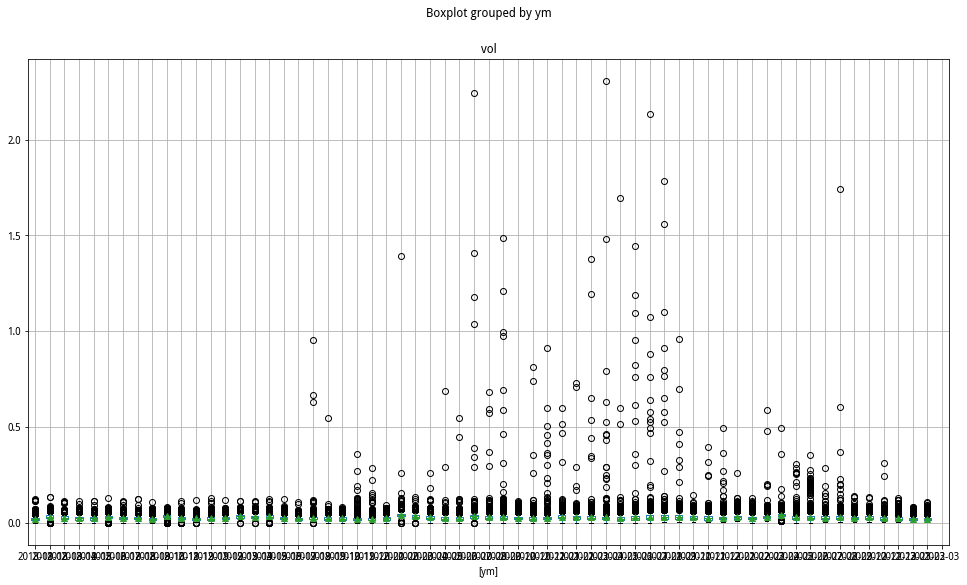

In [148]:
vol_df.loc[vol_df['ym']>='2018',['ym','vol']].boxplot(by='ym',showmeans=True)

In [149]:
vol_df['vol_clip'] = vol_df['vol'].clip(lower=vol_df['vol'].quantile(0.001),
                                        upper=vol_df['vol'].quantile(0.999))
vol_df['ivol_clip'] = vol_df['idiovol1m'].clip(lower=vol_df['idiovol1m'].quantile(0.001),
                                               upper=vol_df['idiovol1m'].quantile(0.999))

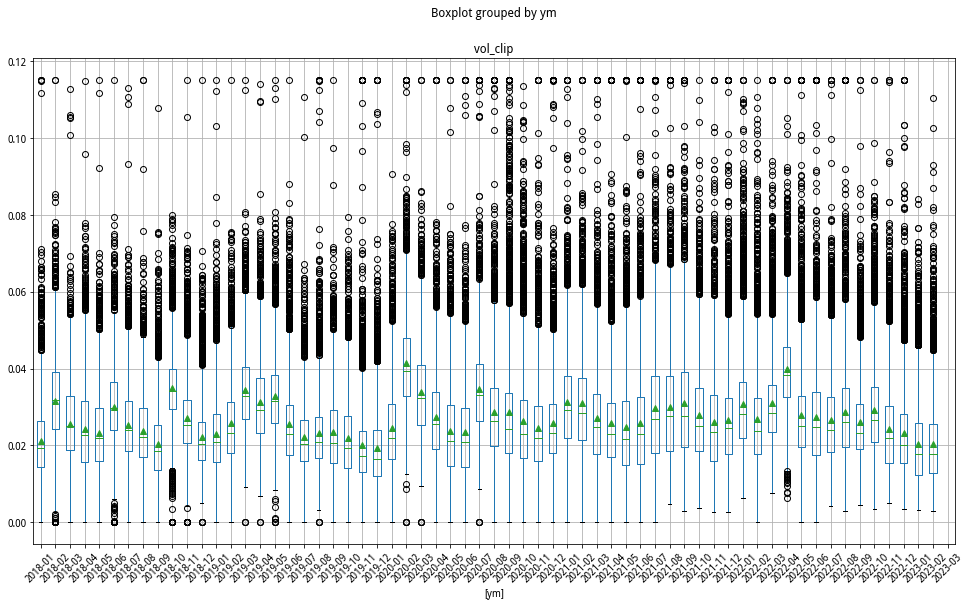

In [150]:
vol_df.loc[vol_df['ym']>='2018',['ym','vol_clip']].boxplot(by='ym',showmeans=True,rot=45)

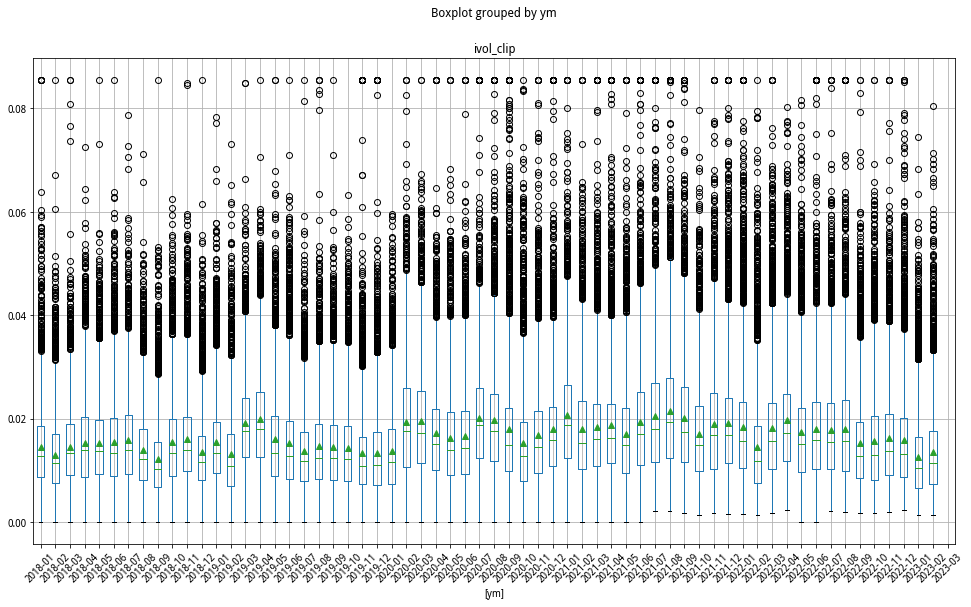

In [151]:
vol_df.loc[vol_df['ym']>='2018',['ym','ivol_clip']].boxplot(by='ym',showmeans=True,rot=45)

In [152]:
vol_df.loc[:,'vol':'ivol_clip'].describe()

vol     idiovol1m       vol_clip     ivol_clip
count  525390.000000  5.110370e+05  525390.000000  5.110370e+05
mean        0.027917  1.620095e-02       0.027690  1.605487e-02
std         0.021330  1.494475e-02       0.013851  9.618317e-03
min         0.000000  3.370719e-08       0.000000  3.560242e-07
25%         0.018179  9.364525e-03       0.018179  9.364525e-03
50%         0.025322  1.408988e-02       0.025322  1.408988e-02
75%         0.034918  2.080131e-02       0.034918  2.080131e-02
max         4.874535  3.583458e+00       0.114991  8.540359e-02

In [153]:
vol_df.rename(columns={'idiovol1m':'ivol'},inplace=True)

## Sorting and Factors

In [154]:
ret_df = pd.merge(ret_df,vol_df,
                  on=['secID','ym'])

In [155]:
ret_df

secID ret_date  tradeDate       ret        rf     exret  \
0       000001.XSHE  2007-07 2007-06-29  0.316497  0.002481  0.314016   
1       000001.XSHE  2007-08 2007-07-31  0.048855  0.002404  0.046451   
2       000001.XSHE  2007-09 2007-08-31  0.052105  0.002621  0.049484   
3       000001.XSHE  2007-10 2007-09-28  0.201851  0.003095  0.198756   
4       000001.XSHE  2007-11 2007-10-31 -0.249116  0.003780 -0.252896   
5       000001.XSHE  2007-12 2007-11-30  0.069845  0.003011  0.066834   
6       000001.XSHE  2008-01 2007-12-28 -0.137306  0.002949 -0.140255   
7       000001.XSHE  2008-02 2008-01-31 -0.004504  0.002946 -0.007450   
...             ...      ...        ...       ...       ...       ...   
547250  689009.XSHG  2022-09 2022-08-31 -0.129911  0.001426 -0.131337   
547251  689009.XSHG  2022-10 2022-09-30 -0.164709  0.001400 -0.166109   
547252  689009.XSHG  2022-11 2022-10-31  0.043125  0.001596  0.041529   
547253  689009.XSHG  2022-12 2022-11-30 -0.086579  0.001955 -0.088534   
547254  689009.XSHG  2023-01 2022-12-30  0.088554  0.001856  0.086698   
547255  689009.XSHG  2023-02 2023-01-31 -0.005725  0.001910 -0.007635   
547256  689009.XSHG  2023-03 2023-02-28 -0.011818  0.001970 -0.013788   
547257  689009.XSHG      NaT 2023-03-10       NaN       NaN       NaN   

             ym        mktcap       size       rev mom_date       mom    beta  \
0       2007-06  4.266117e+10  24.476555       NaN      NaT       NaN  0.4614   
1       2007-07  5.616330e+10  24.751529  0.314016  2007-06       NaN  0.6423   
2       2007-08  5.890714e+10  24.799228  0.046451  2007-07       NaN  0.7722   
3       2007-09  6.197651e+10  24.850021  0.049484  2007-08       NaN  0.7596   
4       2007-10  7.448652e+10  25.033884  0.198756  2007-09       NaN  0.7988   
5       2007-11  5.593078e+10  24.747381 -0.252896  2007-10       NaN  0.9560   
6       2007-12  6.574629e+10  24.909069  0.066834  2007-11       NaN  0.9468   
7       2008-01  5.850212e+10  24.792329 -0.140255  2007-12       NaN  0.9654   
...         ...           ...        ...       ...      ...       ...     ...   
547250  2022-08  2.240616e+10  23.832602 -0.113907  2022-07 -0.338400  0.8589   
547251  2022-09  1.949535e+10  23.693442 -0.131337  2022-08 -0.455748  0.9106   
547252  2022-10  1.637440e+10  23.518985 -0.166109  2022-09 -0.401406  0.7083   
547253  2022-11  1.708055e+10  23.561206  0.041529  2022-10 -0.474030  0.7363   
547254  2022-12  1.560173e+10  23.470648 -0.088534  2022-11 -0.523619  0.6919   
547255  2023-01  1.698332e+10  23.555498  0.086698  2022-12 -0.498602  0.7379   
547256  2023-02  1.688610e+10  23.549757 -0.007635  2023-01 -0.418230  0.7453   
547257  2023-03  1.668654e+10  23.537868 -0.013788  2023-02 -0.246403     NaN   

              bm     illiq  illiq_12m       vol      ivol  vol_clip  ivol_clip  
0       0.123739       NaN        NaN       NaN       NaN       NaN        NaN  
1       0.093992  0.000040        NaN  0.041604       NaN  0.041604        NaN  
2       0.097085  0.000020        NaN  0.033926       NaN  0.033926        NaN  
3       0.092276  0.000025        NaN  0.023872       NaN  0.023872        NaN  
4       0.083411  0.000030        NaN  0.035921       NaN  0.035921        NaN  
5       0.111084  0.000048        NaN  0.033184       NaN  0.033184        NaN  
6       0.094476  0.000025        NaN  0.026541       NaN  0.026541        NaN  
7       0.109513  0.000039        NaN  0.037722  0.012909  0.037722   0.012909  
...          ...       ...        ...       ...       ...       ...        ...  
547250  0.146757  0.000135   0.000205  0.038345  0.031924  0.038345   0.031924  
547251  0.168319  0.000223   0.000203  0.020987  0.015547  0.020987   0.015547  
547252  0.209701  0.000264   0.000206  0.059961  0.051851  0.059961   0.051851  
547253  0.201033  0.000122   0.000202  0.017044  0.010108  0.017044   0.010108  
547254  0.220085  0.000194   0.000210  0.019017  0.013598  0.019017   0.013598  
547255  0.201772  0.00010

In [156]:
def single_sort(df, sort):
    q = dict()
    keys = ['q'+str(i) for i in range(1, 10)]
    values = np.arange(0.1, 1.0, 0.1)
    q.update(zip(keys,values))

    quantile_df = pd.DataFrame()
    for key, value in q.items():
        quantile_df[key] = df.groupby(['ym'])[sort].quantile(value)

    df_q = pd.merge(df, quantile_df, on='ym')

    portfolios = dict()
    drop_cols = [col for col in df_q.columns if col[0]=='q']

    portfolios['p1'] = df_q.loc[df_q[sort] <= df_q['q1']].copy().drop(drop_cols, axis=1)
    for i in range(2,10):
        idx = (df_q[f'q{i-1}'] <= df_q[sort]) & (df_q[sort] <= df_q[f'q{i}'])
        portfolios[f'p{i}'] = df_q.loc[idx].copy().drop(drop_cols, axis=1)
    portfolios['p10'] = df_q.loc[df_q[sort] >= df_q['q9']].copy().drop(drop_cols, axis=1)

    portfolios_crs_mean = dict()
    for k in portfolios.keys():
        portfolios_crs_mean[k] = portfolios[k].groupby(['ret_date'])['exret'].mean()

    mean_values = {}
    t_values = {}
    for k in portfolios_crs_mean.keys():
        y = portfolios_crs_mean[k]
        const = np.full(shape=len(y),fill_value=1)
        reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
        mean_values[k] = reg.params[0]
        t_values[k] = reg.tvalues[0]
    # Portfolio 10-1
    y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
    const = np.full(shape=len(y), fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values['p10-p1'] = reg.params[0]
    t_values['p10-p1'] = reg.tvalues[0]

    display(pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
                 columns=mean_values.keys()))

### Raw volatility

In [157]:
single_sort(ret_df, 'vol')

p1        p2        p3        p4        p5        p6        p7  \
mean     0.012056  0.012966  0.013997  0.014682  0.014882  0.014675  0.012674   
t-value  1.645854  1.839961  1.917470  1.996874  1.981776  1.997934  1.667159   

               p8        p9       p10    p10-p1  
mean     0.010810  0.008643 -0.001590 -0.013646  
t-value  1.408603  1.123466 -0.207818 -4.362738

In [158]:
portfolios = double_sort(ret_df, sort1='vol')

mean_portfolios_ret = dict()
for pf in portfolios.keys():
    mean_portfolios_ret[pf] = portfolios[pf].groupby('ret_date')['exret'].mean()
    print(mean_portfolios_ret[pf].shape) # print 看一下会不会存在某个月份上没有vol和size分组没有任何交叉

# Fast merge by stacking
mean_portfolios_ret_df = pd.DataFrame(np.vstack([pf for pf in mean_portfolios_ret.values()])).T
mean_portfolios_ret_df.columns = mean_portfolios_ret.keys()
mean_portfolios_ret_df.index = mean_portfolios_ret['vol1_size1'].index

# Newey-West adjustment
mean_values = {}
t_values = {}
for k in mean_portfolios_ret.keys():
    y = mean_portfolios_ret[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=4)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

(193,)
(193,)
(193,)
(193,)
(193,)
(193,)


vol1_size1  vol1_size2  vol2_size1  vol2_size2  vol3_size1  \
ret_mean    0.020003    0.007524    0.018929    0.009187    0.009517   
t_values    2.635516    1.133892    2.503277    1.245988    1.203807   

          vol3_size2  
ret_mean    0.002419  
t_values    0.322895

In [159]:
cols = ['beta','size','bm','mom','rev','illiq','vol']
temp = ret_df.groupby('ret_date').apply(fm_reg, cols=cols)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept'] + cols
reg_result_df.dropna(inplace=True)
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

intercept      beta      size        bm       mom       rev  \
ret_mean   0.065333  0.004411 -0.002743  0.003962  0.000662 -0.035199   
t_values   2.038490  1.087469 -2.129583  0.948853  0.245440 -4.056632   

              illiq       vol  
ret_mean  10.258893 -0.368005  
t_values   5.208879 -4.367326

In [160]:
cols = ['beta','size','bm','mom','rev','illiq','vol_clip']
temp = ret_df.groupby('ret_date').apply(fm_reg, cols=cols)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept'] + cols
reg_result_df.dropna(inplace=True)
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

intercept      beta      size        bm       mom       rev  \
ret_mean   0.065341  0.004411 -0.002743  0.003961  0.000663 -0.035194   
t_values   2.038640  1.087514 -2.129682  0.948740  0.245695 -4.055920   

              illiq  vol_clip  
ret_mean  10.258291 -0.368035  
t_values   5.208347 -4.367335

### Idiosyncratic volatility

In [161]:
single_sort(ret_df, 'ivol')

p1        p2        p3        p4        p5        p6        p7  \
mean     0.013512  0.011956  0.013690  0.011193  0.011478  0.009662  0.006977   
t-value  1.806245  1.742167  1.854385  1.653900  1.612297  1.363602  0.999676   

               p8        p9       p10    p10-p1  
mean     0.005120  0.001761 -0.006930 -0.020443  
t-value  0.722113  0.242655 -0.947251 -6.920532

In [162]:
portfolios = double_sort(ret_df, sort1='ivol')

mean_portfolios_ret = dict()
for pf in portfolios.keys():
    mean_portfolios_ret[pf] = portfolios[pf].groupby('ret_date')['exret'].mean()
    print(mean_portfolios_ret[pf].shape) # print 看一下会不会存在某个月份上没有vol和size分组没有任何交叉

# Fast merge by stacking
mean_portfolios_ret_df = pd.DataFrame(np.vstack([pf for pf in mean_portfolios_ret.values()])).T
mean_portfolios_ret_df.columns = mean_portfolios_ret.keys()
mean_portfolios_ret_df.index = mean_portfolios_ret['ivol1_size1'].index

# Newey-West adjustment
mean_values = {}
t_values = {}
for k in mean_portfolios_ret.keys():
    y = mean_portfolios_ret[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=4)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

(182,)
(182,)
(182,)
(182,)
(182,)
(182,)


ivol1_size1  ivol1_size2  ivol2_size1  ivol2_size2  ivol3_size1  \
ret_mean     0.021347     0.005865     0.015185     0.004704     0.003163   
t_values     2.782054     0.872709     2.028772     0.688441     0.412707   

          ivol3_size2  
ret_mean    -0.003225  
t_values    -0.455565

In [163]:
cols = ['beta','size','bm','mom','rev','illiq','ivol_clip']
temp = ret_df.groupby('ret_date').apply(fm_reg, cols=cols)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept'] + cols
reg_result_df.dropna(inplace=True)
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

intercept      beta      size        bm       mom       rev  \
ret_mean   0.081831  0.001002 -0.003194  0.001568  0.001096 -0.026351   
t_values   2.387697  0.237947 -2.357602  0.364237  0.393414 -3.185438   

             illiq  ivol_clip  
ret_mean  9.682441  -0.725699  
t_values  4.994886 -10.576834

In [164]:
cols = ['beta','size','bm','mom','rev','illiq','ivol_clip']
temp = ret_df[ret_df['ret_date']>='2015'].groupby('ret_date').apply(fm_reg, cols=cols)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept'] + cols
reg_result_df.dropna(inplace=True)
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

intercept      beta      size        bm       mom       rev  \
ret_mean   0.078654  0.000045 -0.002768 -0.000345  0.001856 -0.027253   
t_values   1.486866  0.012450 -1.328694 -0.067512  0.685191 -2.164297   

              illiq  ivol_clip  
ret_mean  10.588886  -0.703171  
t_values   3.210447  -7.550546

In [165]:
cols = ['beta','size','bm','mom','rev','illiq','ivol_clip']
temp = ret_df[ret_df['ret_date']>='2018'].groupby('ret_date').apply(fm_reg, cols=cols)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept'] + cols
reg_result_df.dropna(inplace=True)
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

intercept      beta      size        bm       mom       rev  \
ret_mean   0.043651  0.005640 -0.001623 -0.001292  0.003480 -0.021817   
t_values   1.001647  1.557143 -0.935706 -0.258537  1.059149 -1.469622   

             illiq  ivol_clip  
ret_mean  6.852228  -0.637528  
t_values  2.487196  -7.990837

In [166]:
ivol_factor = factor(ret_df, sort1='ivol',long_high=False,long_only=False)

In [167]:
ivol_factor

ret_date
2008-02   -0.024172
2008-03    0.049679
2008-04   -0.011838
2008-05   -0.012252
2008-06    0.019351
2008-07   -0.009882
2008-08    0.083089
2008-09   -0.015782
             ...   
2022-08    0.060485
2022-09    0.022644
2022-10   -0.016821
2022-11    0.039366
2022-12    0.030901
2023-01    0.017861
2023-02    0.022482
2023-03    0.007395
Freq: M, Name: ivol, Length: 182, dtype: float64

In [168]:
factors_df = pd.merge(factors_df,ivol_factor,on='ret_date',how='left')

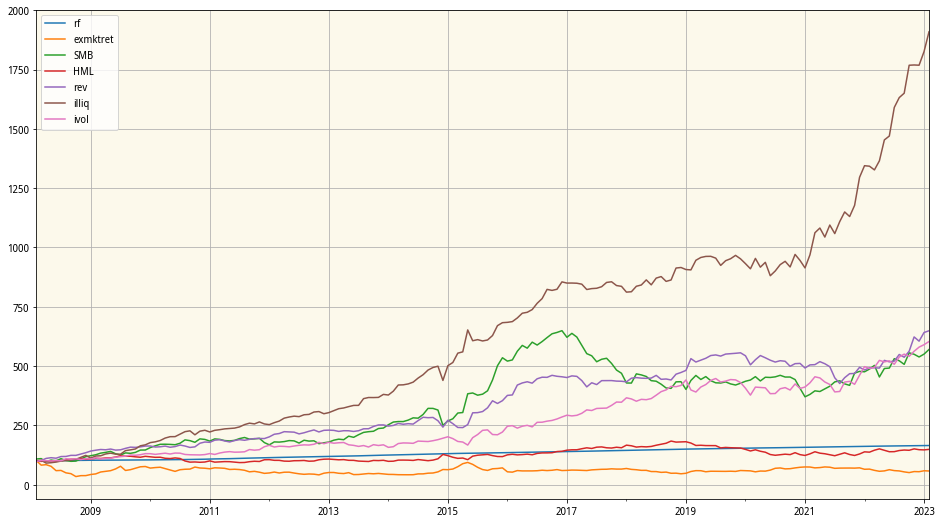

In [169]:
ax = ((factors_df+1).cumprod()*100).plot(grid=True)
ax.set_facecolor("#fcf9eb")
ax.set_xlabel("")
fig = ax.get_figure()
fig.savefig('quant.png',bbox_inches='tight')

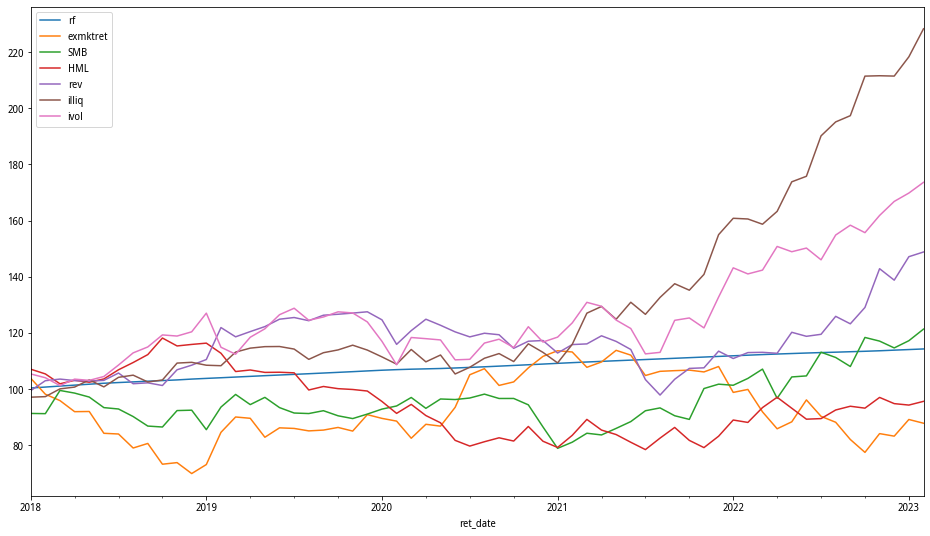

In [170]:
((factors_df['2018':]+1).cumprod()*100).plot()

In [171]:
factors_df.to_pickle('./output_data/factors/factors_all.pkl')

## Output factor exposures

In [172]:
ret_df

secID ret_date  tradeDate       ret        rf     exret  \
0       000001.XSHE  2007-07 2007-06-29  0.316497  0.002481  0.314016   
1       000001.XSHE  2007-08 2007-07-31  0.048855  0.002404  0.046451   
2       000001.XSHE  2007-09 2007-08-31  0.052105  0.002621  0.049484   
3       000001.XSHE  2007-10 2007-09-28  0.201851  0.003095  0.198756   
4       000001.XSHE  2007-11 2007-10-31 -0.249116  0.003780 -0.252896   
5       000001.XSHE  2007-12 2007-11-30  0.069845  0.003011  0.066834   
6       000001.XSHE  2008-01 2007-12-28 -0.137306  0.002949 -0.140255   
7       000001.XSHE  2008-02 2008-01-31 -0.004504  0.002946 -0.007450   
...             ...      ...        ...       ...       ...       ...   
547250  689009.XSHG  2022-09 2022-08-31 -0.129911  0.001426 -0.131337   
547251  689009.XSHG  2022-10 2022-09-30 -0.164709  0.001400 -0.166109   
547252  689009.XSHG  2022-11 2022-10-31  0.043125  0.001596  0.041529   
547253  689009.XSHG  2022-12 2022-11-30 -0.086579  0.001955 -0.088534   
547254  689009.XSHG  2023-01 2022-12-30  0.088554  0.001856  0.086698   
547255  689009.XSHG  2023-02 2023-01-31 -0.005725  0.001910 -0.007635   
547256  689009.XSHG  2023-03 2023-02-28 -0.011818  0.001970 -0.013788   
547257  689009.XSHG      NaT 2023-03-10       NaN       NaN       NaN   

             ym        mktcap       size       rev mom_date       mom    beta  \
0       2007-06  4.266117e+10  24.476555       NaN      NaT       NaN  0.4614   
1       2007-07  5.616330e+10  24.751529  0.314016  2007-06       NaN  0.6423   
2       2007-08  5.890714e+10  24.799228  0.046451  2007-07       NaN  0.7722   
3       2007-09  6.197651e+10  24.850021  0.049484  2007-08       NaN  0.7596   
4       2007-10  7.448652e+10  25.033884  0.198756  2007-09       NaN  0.7988   
5       2007-11  5.593078e+10  24.747381 -0.252896  2007-10       NaN  0.9560   
6       2007-12  6.574629e+10  24.909069  0.066834  2007-11       NaN  0.9468   
7       2008-01  5.850212e+10  24.792329 -0.140255  2007-12       NaN  0.9654   
...         ...           ...        ...       ...      ...       ...     ...   
547250  2022-08  2.240616e+10  23.832602 -0.113907  2022-07 -0.338400  0.8589   
547251  2022-09  1.949535e+10  23.693442 -0.131337  2022-08 -0.455748  0.9106   
547252  2022-10  1.637440e+10  23.518985 -0.166109  2022-09 -0.401406  0.7083   
547253  2022-11  1.708055e+10  23.561206  0.041529  2022-10 -0.474030  0.7363   
547254  2022-12  1.560173e+10  23.470648 -0.088534  2022-11 -0.523619  0.6919   
547255  2023-01  1.698332e+10  23.555498  0.086698  2022-12 -0.498602  0.7379   
547256  2023-02  1.688610e+10  23.549757 -0.007635  2023-01 -0.418230  0.7453   
547257  2023-03  1.668654e+10  23.537868 -0.013788  2023-02 -0.246403     NaN   

              bm     illiq  illiq_12m       vol      ivol  vol_clip  ivol_clip  
0       0.123739       NaN        NaN       NaN       NaN       NaN        NaN  
1       0.093992  0.000040        NaN  0.041604       NaN  0.041604        NaN  
2       0.097085  0.000020        NaN  0.033926       NaN  0.033926        NaN  
3       0.092276  0.000025        NaN  0.023872       NaN  0.023872        NaN  
4       0.083411  0.000030        NaN  0.035921       NaN  0.035921        NaN  
5       0.111084  0.000048        NaN  0.033184       NaN  0.033184        NaN  
6       0.094476  0.000025        NaN  0.026541       NaN  0.026541        NaN  
7       0.109513  0.000039        NaN  0.037722  0.012909  0.037722   0.012909  
...          ...       ...        ...       ...       ...       ...        ...  
547250  0.146757  0.000135   0.000205  0.038345  0.031924  0.038345   0.031924  
547251  0.168319  0.000223   0.000203  0.020987  0.015547  0.020987   0.015547  
547252  0.209701  0.000264   0.000206  0.059961  0.051851  0.059961   0.051851  
547253  0.201033  0.000122   0.000202  0.017044  0.010108  0.017044   0.010108  
547254  0.220085  0.000194   0.000210  0.019017  0.013598  0.019017   0.013598  
547255  0.201772  0.00010

In [173]:
ret_df.to_pickle('./output_data/factor_exposure/all_exposure.pkl')

In [174]:
cols = ['size','bm','rev','illiq','ivol']

In [175]:
ret_df[['secID','tradeDate','rev']].dropna().pivot(index='tradeDate',
                                                columns='secID',values='rev')

secID       000001.XSHE  000002.XSHE  000004.XSHE  000005.XSHE  000006.XSHE  \
tradeDate                                                                     
2007-02-28          NaN    -0.039341          NaN          NaN     0.079198   
2007-03-30          NaN     0.123274          NaN          NaN     0.101648   
2007-04-30          NaN     0.087689          NaN          NaN     0.418516   
2007-05-31          NaN     0.618401          NaN          NaN     0.327713   
2007-06-29          NaN    -0.017483          NaN          NaN    -0.065749   
2007-07-02          NaN          NaN          NaN          NaN          NaN   
2007-07-31     0.314016     0.477643          NaN          NaN     0.282658   
2007-08-31     0.046451     0.191943          NaN          NaN    -0.032089   
...                 ...          ...          ...          ...          ...   
2022-09-30    -0.072799     0.070733          NaN          NaN    -0.020428   
2022-10-31    -0.128089    -0.243127          NaN          NaN    -0.115199   
2022-11-21          NaN          NaN          NaN          NaN          NaN   
2022-11-30     0.258559     0.377842          NaN          NaN     0.594032   
2022-12-30     0.008022    -0.026084          NaN          NaN     0.076812   
2023-01-31     0.137202     0.003089          NaN          NaN    -0.106618   
2023-02-28    -0.082630    -0.064786          NaN          NaN     0.014048   
2023-03-10    -0.048414    -0.078399          NaN          NaN    -0.015931   

secID       000007.XSHE  000008.XSHE  000009.XSHE  000010.XSHE  000011.XSHE  \
tradeDate                                                                     
2007-02-28     0.293391     0.140721          NaN          NaN          NaN   
2007-03-30     0.318730     0.177471          NaN          NaN          NaN   
2007-04-30     0.204700          NaN          NaN          NaN          NaN   
2007-05-31          NaN          NaN          NaN          NaN          NaN   
2007-06-29          NaN          NaN          NaN          NaN          NaN   
2007-07-02          NaN          NaN          NaN          NaN          NaN   
2007-07-31          NaN          NaN          NaN          NaN          NaN   
2007-08-31          NaN          NaN          NaN          NaN          NaN   
...                 ...          ...          ...          ...          ...   
2022-09-30     0.001066    -0.088561    -0.241263    -0.109066    -0.085171   
2022-10-31    -0.008846     0.021314     0.028907    -0.036315    -0.000331   
2022-11-21          NaN          NaN          NaN          NaN          NaN   
2022-11-30    -0.059094     0.078417     0.131618     0.097076     0.224498   
2022-12-30     0.029871    -0.055461    -0.079051     0.120812     0.025534   
2023-01-31    -0.022422     0.059024     0.033713    -0.084544    -0.019974   
2023-02-28     0.013841     0.034966     0.020448    -0.036769     0.006865   
2023-03-10    -0.001970    -0.017783    -0.057435    -0.023076    -0.049004   

secID       ...  688787.XSHG  688788.XSHG  688789.XSHG  688793.XSHG  \
tradeDate   ...                                                       
2007-02-28  ...          NaN          NaN          NaN          NaN   
2007-03-30  ...          NaN          NaN          NaN          NaN   
2007-04-30  ...          NaN          NaN          NaN          NaN   
2007-05-31  ...          NaN          NaN          NaN          NaN   
2007-06-29  ...          NaN          NaN          NaN          NaN   
2007-07-02  ...          NaN          NaN          NaN          NaN   
2007-07-31  ...          NaN          NaN          NaN          NaN   
2007-08-31  ...          NaN          NaN          NaN          NaN   
...         ...          ...          ...          ...          ...   
2022-09-30  ...    -0.115983    -0.136127    -0.264406    -0.011271   
2022-10-31  ...     0.394736     0.257566     0.157716    -0.053712   
2022-11-21  ...          NaN          NaN          NaN          NaN   
20

In [176]:
temp = ret_df[['secID','tradeDate','size']].dropna().pivot(index='tradeDate',
                                                columns='secID',values='size').reset_index()
temp['tradeDate'] = temp['tradeDate'].dt.strftime('%Y/%m/%d')
temp.set_index('tradeDate')

secID       000001.XSHE  000002.XSHE  000004.XSHE  000005.XSHE  000006.XSHE  \
tradeDate                                                                     
2007/02/28          NaN    24.593794          NaN          NaN    21.759995   
2007/03/30          NaN    24.712034          NaN          NaN    21.858822   
2007/04/30          NaN    24.798040          NaN          NaN    22.209934   
2007/05/31          NaN    25.274487          NaN          NaN    22.482926   
2007/06/29    24.476555    25.259434          NaN          NaN    22.417635   
2007/07/02          NaN          NaN          NaN          NaN          NaN   
2007/07/31    24.751529    25.651961          NaN          NaN    22.668582   
2007/08/31    24.799228    25.892469          NaN          NaN    22.638445   
...                 ...          ...          ...          ...          ...   
2022/09/30    26.160308    25.878082          NaN          NaN    22.441644   
2022/10/31    26.024845    25.601370          NaN          NaN    22.320830   
2022/11/21          NaN          NaN          NaN          NaN          NaN   
2022/11/30    26.256079    25.923046          NaN          NaN    22.788098   
2022/12/30    26.266007    25.898621          NaN          NaN    22.863916   
2023/01/31    26.396208    25.903554          NaN          NaN    22.753251   
2023/02/28    26.312043    25.838615          NaN          NaN    22.769082   
2023/03/10    26.264486    25.759087          NaN          NaN    22.755022   

secID       000007.XSHE  000008.XSHE  000009.XSHE  000010.XSHE  000011.XSHE  \
tradeDate                                                                     
2007/02/28    19.937819    19.417744          NaN          NaN          NaN   
2007/03/30    20.216174    19.582993          NaN          NaN          NaN   
2007/04/30    20.404169          NaN          NaN          NaN          NaN   
2007/05/31          NaN          NaN          NaN          NaN          NaN   
2007/06/29          NaN          NaN          NaN          NaN          NaN   
2007/07/02          NaN          NaN          NaN          NaN          NaN   
2007/07/31          NaN          NaN          NaN          NaN          NaN   
2007/08/31          NaN          NaN          NaN          NaN          NaN   
...                 ...          ...          ...          ...          ...   
2022/09/30    21.635597    22.502933    24.077618    21.220909    22.299831   
2022/10/31    21.628125    22.525406    24.107471    21.185364    22.300919   
2022/11/21          NaN          NaN          NaN          NaN          NaN   
2022/11/30    21.568906    22.602367    24.232532    21.279477    22.504747   
2022/12/30    21.600240    22.547385    24.152299    21.395262    22.531858   
2023/01/31    21.579460    22.582276    24.187247    21.308978    22.513573   
2023/02/28    21.595085    22.618497    24.209365    21.273471    22.522322   
2023/03/10    21.595085    22.602561    24.152299    21.252161    22.474141   

secID       ...  688787.XSHG  688788.XSHG  688789.XSHG  688793.XSHG  \
tradeDate   ...                                                       
2007/02/28  ...          NaN          NaN          NaN          NaN   
2007/03/30  ...          NaN          NaN          NaN          NaN   
2007/04/30  ...          NaN          NaN          NaN          NaN   
2007/05/31  ...          NaN          NaN          NaN          NaN   
2007/06/29  ...          NaN          NaN          NaN          NaN   
2007/07/02  ...          NaN          NaN          NaN          NaN   
2007/07/31  ...          NaN          NaN          NaN          NaN   
2007/08/31  ...          NaN          NaN          NaN          NaN   
...         ...          ...          ...          ...          ...   
2022/09/30  ...    20.957681    21.546790    22.497171    20.600879   
2022/10/31  ...    21.291406    21.789237    22.644828    20.547132   
2022/11/21  ...          NaN          NaN          NaN          NaN   
20

In [177]:
for c in cols:
    temp = ret_df[['secID','tradeDate',c]].dropna().pivot(index='tradeDate',columns='secID',values=c)
    temp.reset_index(inplace=True)
    temp['tradeDate'] = temp['tradeDate'].dt.strftime('%Y/%m/%d')
    temp.set_index('tradeDate',inplace=True)
    temp.to_csv(f'./output_data/factor_exposure/{c}_exposure.csv')

## Long-only ivol factor

In [178]:
factors_daily = pd.read_pickle('./output_data/factors/factors_daily_long_only.pkl')
illiq_daily = daily_factor(ret_df, stock_df=stk_df,sort1='illiq',long_only=True)
illiq_daily.name = 'illiq_long'
factors_daily = pd.merge(factors_daily, illiq_daily, on='tradeDate')

In [179]:
reg_df = pd.merge(stk_df[['secID','tradeDate','ret_daily']],factors_daily,
                  on=['tradeDate'])
reg_df.sort_values(['secID','tradeDate'],inplace=True)
reg_df['exret'] = reg_df['ret_daily'] - reg_df['rf']
reg_df['ym'] = reg_df['tradeDate'].dt.to_period('M')

In [180]:
reg_df.set_index('ym',inplace=True)

In [181]:
reg_df

secID  tradeDate  ret_daily        rf  exmktret  size_long  \
ym                                                                          
2007-06  000001.XSHE 2007-06-20   0.197544  0.000073 -0.024256  -0.027120   
2007-06  000001.XSHE 2007-06-21   0.100033  0.000064  0.005827  -0.004360   
2007-06  000001.XSHE 2007-06-22   0.031769  0.000058 -0.040473  -0.060460   
2007-06  000001.XSHE 2007-06-25  -0.005650  0.000052 -0.048566  -0.069969   
2007-06  000001.XSHE 2007-06-26   0.000000  0.000049  0.014660   0.017840   
2007-06  000001.XSHE 2007-06-27  -0.084659  0.000047  0.027391   0.025536   
2007-06  000001.XSHE 2007-06-28  -0.064557  0.000046 -0.050035  -0.071769   
2007-06  000001.XSHE 2007-06-29  -0.086928  0.000049 -0.029572  -0.049110   
...              ...        ...        ...       ...       ...        ...   
2023-03  689009.XSHG 2023-03-01   0.016364  0.000057  0.012218   0.009576   
2023-03  689009.XSHG 2023-03-02   0.029815  0.000044 -0.002502  -0.004121   
2023-03  689009.XSHG 2023-03-03   0.000869  0.000035  0.002599  -0.001130   
2023-03  689009.XSHG 2023-03-06  -0.019670  0.000034 -0.003703   0.001321   
2023-03  689009.XSHG 2023-03-07  -0.015344  0.000039 -0.015381  -0.023023   
2023-03  689009.XSHG 2023-03-08   0.021277  0.000045 -0.002034   0.011766   
2023-03  689009.XSHG 2023-03-09  -0.019660  0.000038 -0.003295   0.004052   
2023-03  689009.XSHG 2023-03-10  -0.023945  0.000050 -0.013107  -0.013349   

          bm_long  mom_long  rev_long  illiq_long     exret  
ym                                                           
2007-06 -0.025430       NaN -0.024854   -0.025328  0.197470  
2007-06  0.000312       NaN  0.001203   -0.010721  0.099969  
2007-06 -0.059817       NaN -0.057332   -0.052408  0.031711  
2007-06 -0.069842       NaN -0.064464   -0.055035 -0.005702  
2007-06  0.025272       NaN  0.021764    0.019832 -0.000049  
2007-06  0.022837       NaN  0.025378    0.026533 -0.084706  
2007-06 -0.061015       NaN -0.060412   -0.059985 -0.064602  
2007-06 -0.038481       NaN -0.044104   -0.043622 -0.086977  
...           ...       ...       ...         ...       ...  
2023-03  0.010064  0.007884  0.008847    0.007525  0.016306  
2023-03  0.001421 -0.004647 -0.006972   -0.001168  0.029771  
2023-03  0.005110  0.001201  0.001663   -0.002636  0.000833  
2023-03 -0.004066  0.002348  0.000525    0.005455 -0.019704  
2023-03 -0.013322 -0.017141 -0.019231   -0.019660 -0.015383  
2023-03  0.004463  0.003286  0.002833    0.009819  0.021231  
2023-03 -0.000113 -0.002199 -0.000922    0.003399 -0.019697  
2023-03 -0.015975 -0.016233 -0.012754   -0.014355 -0.023995  

[10954954 rows x 11 columns]

In [182]:
gc.collect()

552

In [183]:
# import sys
# def sizeof_fmt(num, suffix='B'):
#     ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
#     for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
#         if abs(num) < 1024.0:
#             return "%3.1f %s%s" % (num, unit, suffix)
#         num /= 1024.0
#     return "%.1f %s%s" % (num, 'Yi', suffix)

# for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
#                          key= lambda x: -x[1])[:10]:
#     print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

               stk_unfilled_df:  2.5 GiB
                          _114:  1.6 GiB
                          _116:  1.6 GiB
                          _139:  1.6 GiB
                            __:  1.6 GiB
                        reg_df:  1.6 GiB
                          _181:  1.6 GiB
                        stk_df:  1.5 GiB
                           _97:  1.5 GiB
                       beta_df: 980.2 MiB


In [184]:
# del stk_unfilled_df, beta_df

In [185]:
# del _114

In [186]:
# del _116, _139, __, _181, _97

In [187]:
# %%time
# ivol = reg_df.groupby(['secID']).apply(idiovol_np, factor_cols=['exmktret','size_long','bm_long','mom_long','rev_long','illiq_long'])
# # Takes about 27min 25s to execute

CPU times: user 29min 4s, sys: 37.1 s, total: 29min 41s
Wall time: 29min 47s


In [190]:
# ivol = ivol.reset_index().drop('level_1',axis=1)
# display(ivol)
# ivol.to_pickle('./data/idiovol1m_long_only.pkl')

In [191]:
vol_df = stk_df.groupby(['secID','ym'])['ret_daily'].std()
vol_df = vol_df.to_frame()
vol_df.columns = ['vol']
vol_df.reset_index(inplace=True)
MIN_NOBS = 15
idx = stk_df.groupby(['secID','ym'],as_index=False)['tradeDate'].count()['tradeDate'] < MIN_NOBS
vol_df.loc[idx, 'vol'] = np.nan

In [192]:
ivol = pd.read_pickle('./data/idiovol1m_long_only.pkl')
vol_df = pd.merge(vol_df,ivol,on=['secID','ym'])
vol_df['vol_clip'] = vol_df['vol'].clip(lower=vol_df['vol'].quantile(0.001),
                                        upper=vol_df['vol'].quantile(0.999))
vol_df['ivol_clip'] = vol_df['idiovol1m'].clip(lower=vol_df['idiovol1m'].quantile(0.001),
                                               upper=vol_df['idiovol1m'].quantile(0.999))
vol_df.rename(columns={'idiovol1m':'ivol'},inplace=True)

In [193]:
try:
    ret_df.drop(['vol','ivol','vol_clip','ivol_clip'],axis=1,inplace=True)
except KeyError:
    pass

In [194]:
ret_df = pd.merge(ret_df,vol_df,
                  on=['secID','ym'])

In [195]:
ret_df

secID ret_date  tradeDate       ret        rf     exret  \
0       000001.XSHE  2007-07 2007-06-29  0.316497  0.002481  0.314016   
1       000001.XSHE  2007-08 2007-07-31  0.048855  0.002404  0.046451   
2       000001.XSHE  2007-09 2007-08-31  0.052105  0.002621  0.049484   
3       000001.XSHE  2007-10 2007-09-28  0.201851  0.003095  0.198756   
4       000001.XSHE  2007-11 2007-10-31 -0.249116  0.003780 -0.252896   
5       000001.XSHE  2007-12 2007-11-30  0.069845  0.003011  0.066834   
6       000001.XSHE  2008-01 2007-12-28 -0.137306  0.002949 -0.140255   
7       000001.XSHE  2008-02 2008-01-31 -0.004504  0.002946 -0.007450   
...             ...      ...        ...       ...       ...       ...   
546039  689009.XSHG  2022-09 2022-08-31 -0.129911  0.001426 -0.131337   
546040  689009.XSHG  2022-10 2022-09-30 -0.164709  0.001400 -0.166109   
546041  689009.XSHG  2022-11 2022-10-31  0.043125  0.001596  0.041529   
546042  689009.XSHG  2022-12 2022-11-30 -0.086579  0.001955 -0.088534   
546043  689009.XSHG  2023-01 2022-12-30  0.088554  0.001856  0.086698   
546044  689009.XSHG  2023-02 2023-01-31 -0.005725  0.001910 -0.007635   
546045  689009.XSHG  2023-03 2023-02-28 -0.011818  0.001970 -0.013788   
546046  689009.XSHG      NaT 2023-03-10       NaN       NaN       NaN   

             ym        mktcap       size       rev mom_date       mom    beta  \
0       2007-06  4.266117e+10  24.476555       NaN      NaT       NaN  0.4614   
1       2007-07  5.616330e+10  24.751529  0.314016  2007-06       NaN  0.6423   
2       2007-08  5.890714e+10  24.799228  0.046451  2007-07       NaN  0.7722   
3       2007-09  6.197651e+10  24.850021  0.049484  2007-08       NaN  0.7596   
4       2007-10  7.448652e+10  25.033884  0.198756  2007-09       NaN  0.7988   
5       2007-11  5.593078e+10  24.747381 -0.252896  2007-10       NaN  0.9560   
6       2007-12  6.574629e+10  24.909069  0.066834  2007-11       NaN  0.9468   
7       2008-01  5.850212e+10  24.792329 -0.140255  2007-12       NaN  0.9654   
...         ...           ...        ...       ...      ...       ...     ...   
546039  2022-08  2.240616e+10  23.832602 -0.113907  2022-07 -0.338400  0.8589   
546040  2022-09  1.949535e+10  23.693442 -0.131337  2022-08 -0.455748  0.9106   
546041  2022-10  1.637440e+10  23.518985 -0.166109  2022-09 -0.401406  0.7083   
546042  2022-11  1.708055e+10  23.561206  0.041529  2022-10 -0.474030  0.7363   
546043  2022-12  1.560173e+10  23.470648 -0.088534  2022-11 -0.523619  0.6919   
546044  2023-01  1.698332e+10  23.555498  0.086698  2022-12 -0.498602  0.7379   
546045  2023-02  1.688610e+10  23.549757 -0.007635  2023-01 -0.418230  0.7453   
546046  2023-03  1.668654e+10  23.537868 -0.013788  2023-02 -0.246403     NaN   

              bm     illiq  illiq_12m       vol      ivol  vol_clip  ivol_clip  
0       0.123739       NaN        NaN       NaN       NaN       NaN        NaN  
1       0.093992  0.000040        NaN  0.041604       NaN  0.041604        NaN  
2       0.097085  0.000020        NaN  0.033926       NaN  0.033926        NaN  
3       0.092276  0.000025        NaN  0.023872       NaN  0.023872        NaN  
4       0.083411  0.000030        NaN  0.035921       NaN  0.035921        NaN  
5       0.111084  0.000048        NaN  0.033184       NaN  0.033184        NaN  
6       0.094476  0.000025        NaN  0.026541       NaN  0.026541        NaN  
7       0.109513  0.000039        NaN  0.037722  0.013280  0.037722   0.013280  
...          ...       ...        ...       ...       ...       ...        ...  
546039  0.146757  0.000135   0.000205  0.038345  0.027990  0.038345   0.027990  
546040  0.168319  0.000223   0.000203  0.020987  0.014896  0.020987   0.014896  
546041  0.209701  0.000264   0.000206  0.059961  0.052703  0.059961   0.052703  
546042  0.201033  0.000122   0.000202  0.017044  0.010588  0.017044   0.010588  
546043  0.220085  0.000194   0.000210  0.019017  0.013173  0.019017   0.013173  
546044  0.201772  0.00010

In [196]:
single_sort(ret_df, 'ivol')

p1        p2        p3        p4        p5        p6        p7  \
mean     0.013104  0.012524  0.012994  0.011909  0.011996  0.009348  0.006816   
t-value  1.739595  1.798578  1.836292  1.711530  1.699845  1.330995  0.987976   

               p8        p9       p10    p10-p1  
mean     0.004984  0.001509 -0.006766 -0.019870  
t-value  0.692080  0.212925 -0.901901 -6.866117

In [197]:
cols = ['beta','size','bm','mom','rev','illiq','ivol_clip']
temp = ret_df.groupby('ret_date').apply(fm_reg, cols=cols)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept'] + cols
reg_result_df.dropna(inplace=True)

# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

intercept      beta      size        bm       mom       rev  \
ret_mean   0.081706  0.001072 -0.003199  0.001624  0.001091 -0.026893   
t_values   2.376500  0.253940 -2.351836  0.378796  0.388068 -3.238317   

             illiq  ivol_clip  
ret_mean  9.656473  -0.712857  
t_values  4.954442 -10.661975

In [198]:
ivol_factor = factor(ret_df, sort1='ivol',long_high=False,long_only=True)

In [199]:
factors_long_df = pd.merge(factors_long_df,ivol_factor,on='ret_date',how='left')

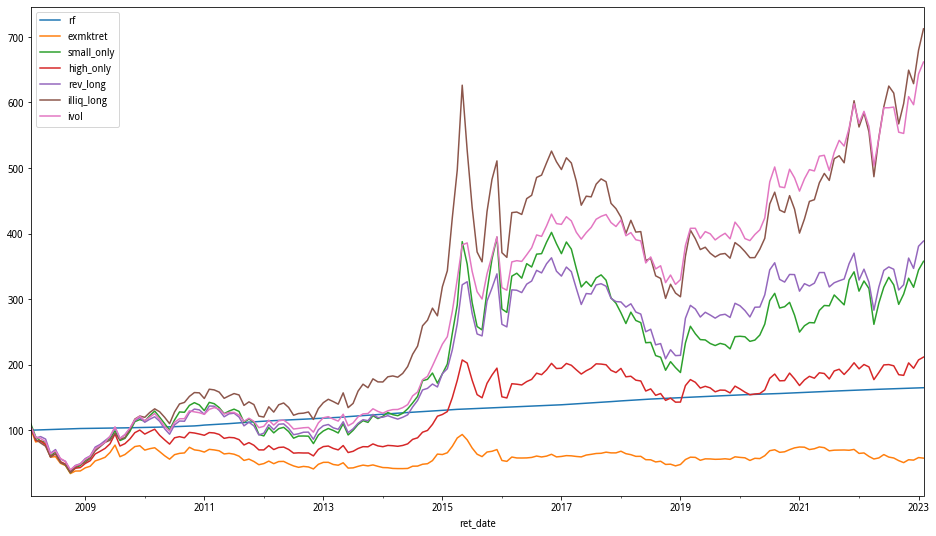

In [200]:
((factors_long_df+1).cumprod()*100).plot()

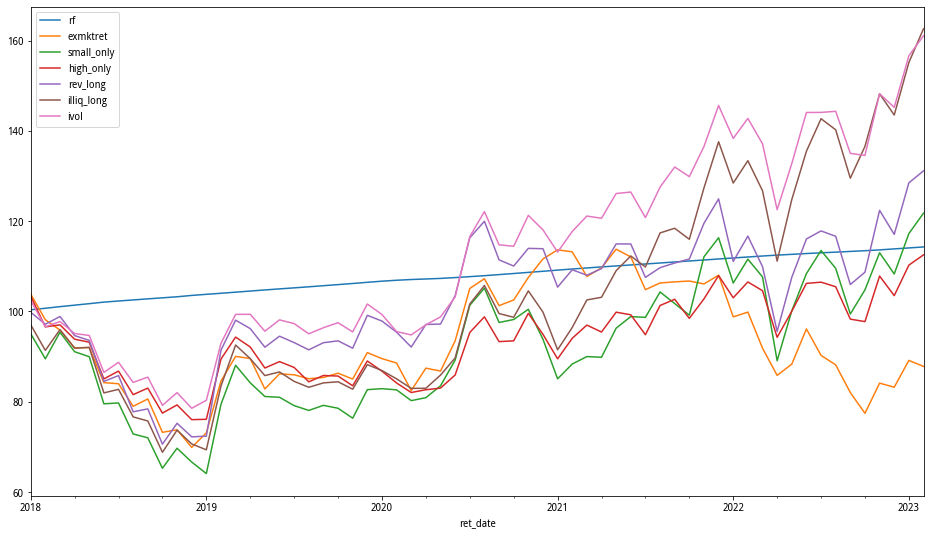

In [201]:
((factors_long_df['2018':]+1).cumprod()*100).plot()

In [202]:
factors_long_df.rename(columns={'ivol':'ivol_long'},inplace=True)

In [203]:
factors_long_df

rf  exmktret  small_only  high_only  rev_long  illiq_long  \
ret_date                                                                    
2008-02   0.002946  0.024010    0.103117   0.059319  0.061518    0.054128   
2008-03   0.002746 -0.195480   -0.180562  -0.202495 -0.167375   -0.180816   
2008-04   0.002862  0.022519   -0.073326  -0.010688  0.024523   -0.063553   
2008-05   0.002953 -0.080798   -0.020022  -0.056407 -0.041619   -0.061992   
2008-06   0.003113 -0.236014   -0.257252  -0.239010 -0.249352   -0.218804   
2008-07   0.002806  0.014972    0.108774   0.072304  0.086448    0.084925   
2008-08   0.002681 -0.170063   -0.232768  -0.187431 -0.203679   -0.206455   
2008-09   0.002889 -0.067913   -0.089285  -0.068049 -0.062323   -0.065761   
...            ...       ...         ...        ...       ...         ...   
2022-07   0.001448 -0.060974    0.047271   0.002560  0.015416    0.053249   
2022-08   0.001251 -0.023276   -0.034803  -0.009445 -0.010168   -0.017149   
2022-09   0.001426 -0.069642   -0.092335  -0.068136 -0.091581   -0.076478   
2022-10   0.001400 -0.056037    0.053699  -0.005541  0.025716    0.054459   
2022-11   0.001596  0.086374    0.078566   0.103273  0.126171    0.085286   
2022-12   0.001955 -0.010731   -0.041613  -0.040295 -0.043517   -0.031697   
2023-01   0.001856  0.071339    0.082598   0.065335  0.097496    0.081029   
2023-02   0.001910 -0.014930    0.038597   0.020645  0.020647    0.048121   

          ivol_long  
ret_date             
2008-02    0.060423  
2008-03   -0.152310  
2008-04   -0.024827  
2008-05   -0.054124  
2008-06   -0.224208  
2008-07    0.067996  
2008-08   -0.165454  
2008-09   -0.080529  
...             ...  
2022-07    0.000079  
2022-08    0.001741  
2022-09   -0.064587  
2022-10   -0.003383  
2022-11    0.101584  
2022-12   -0.020359  
2023-01    0.078637  
2023-02    0.028370  

[181 rows x 7 columns]

In [204]:
factors_long_df.to_pickle('./output_data/factors/factors_all_long_only.pkl')